In [159]:
%load_ext autoreload
%autoreload 2
import sys, os, glob, re, pickle, scipy, torch
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from openbabel import openbabel as ob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import matplotlib as mpl
from colorsys import rgb_to_hls

sys.path.append('/net/pulsar/home/koes/mtr22/param_search')
import param_search

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

base_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')
os.chdir(base_dir)

os.getcwd(), torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('/net/pulsar/home/koes/mtr22/gan/new_atom_typing', True)

In [137]:
def find_work_dirs():
    '''
    Return mapping of job ids to works dirs
    based on stdout and stderr files.
    '''
    work_dir_pat = re.compile(r'^(.+)/(\d+)\.(stdout|stderr)$')
    work_dir_map = defaultdict(lambda: None)
    for f in glob.glob('*/*.std*'):
        m = work_dir_pat.match(f)
        if m:
            work_dir = m.group(1)
            job_id = int(m.group(2))
            if job_id in work_dir_map:
                assert work_dir_map[job_id] == work_dir
            else:
                work_dir_map[job_id] = work_dir
    return work_dir_map

def find_work_dir(x):
    '''
    If jobs are in queue, use the qstat value.
    Otherwise use the work_dir_map.
    '''
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

def find_job_state(x):
    '''
    If jobs are in the queue, use qstat value.
    Else if there's no work dir, assume the job
    was cancelled. If there's stderr, has error.
    '''
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0]) if len(x) == 3 else 0
    minutes = int(x[-2]) if len(x) >= 2 else 0
    seconds = int(x[-1])
    return dt.timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

def get_palette(n_hues, n_shades=1, n_repeat=1, hues=None, min_val=0.0, max_val=1.0, n_samples=100, mode=None):
    assert 0 <= min_val <= 1.0
    assert 0 <= max_val <= 1.0
    
    if hues is None:
        if n_hues <= 9:
            mode = mode or 'muted'
            hues = sns.color_palette(mode)[:n_hues]
        else:
            mode = mode or 'husl'
            hues = sns.color_palette(mode, n_hues)
            
    if not isinstance(n_shades, list):
        n_shades = [n_shades] * len(hues)

    colors = []
    for hue, n_shades in zip(hues, n_shades):
        
        # get n_samples different shades of hue
        shades = (
            sns.dark_palette(hue, n_colors=n_samples//2) + \
            sns.light_palette(hue, n_colors=n_samples//2, reverse=True)
        )
        # limit shade range with min_val and max_val
        min_idx = int(min_val * len(shades))
        max_idx = int(max_val * len(shades))
        shades = shades[min_idx:max_idx]
        
        # get n_shades evenly spaced shades in that range, avoiding endpoints
        vals = np.linspace(0, 1, n_shades + 2)
        idxs = [int(v * (len(shades) - 1)) for v in vals]
        shades = [shades[i] for i in idxs[1:-1]]
        
        # repeat each shade n_repeat times
        shades = sorted(n_repeat * shades, key=lambda x: sum(x))

        colors.extend(shades)
        
    return sns.color_palette(colors)

def get_gray_color(colors):
    light_vals = [rgb_to_hls(*c)[1] for c in colors]
    lum = min(light_vals) * .6
    return mpl.colors.rgb2hex((lum, lum, lum))

class TextHandler(mpl.legend_handler.HandlerBase):
    '''
    Allow text as the handle in a legend.
    '''
    def create_artists(
        self,
        legend,
        text,
        xdescent,
        ydescent,
        width,
        height,
        fontsize,
        trans,
    ):
        txt = mpl.text.Text(
            width/2,
            height/2,
            text,
            fontsize=fontsize,
            ha='center',
            va='center',
        )
        return [txt]

mpl.legend.Legend.update_default_handler_map({str: TextHandler()})

get_palette(n_hues=5, n_shades=[1,2,3,4,5], mode='bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (0.7303055126922927, 0.37401705098309446, 0.043187573664151865),
 (0.9844773267701052, 0.6343974503939503, 0.3054485381797389),
 (0.11765447059964117, 0.4644768631663434, 0.17588467018778384),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.5030029764381416, 0.8687267017335306, 0.563760629977106),
 (0.4706802763783887, 0.0814431506173033, 0.0983586076494307),
 (0.7634293731718812, 0.027147716872434446, 0.06154437248445076),
 (0.9176295076475914, 0.17345829730976864, 0.2086305836444825),
 (0.9349456981201926, 0.557280912633512, 0.574828587670488),
 (0.28221917951149533, 0.1502744739281356, 0.4109591598393532),
 (0.4182437057537802, 0.1597710725191288, 0.6569072188326472),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6752846353959335, 0.42043142881142276, 0.9073661857993561),
 (0.8070397447831716, 0.6752691895078875, 0.928711978373049)]

# Table of contents

1. [Atom type analysis](#1.-Atom-type-analysis)

2. [Bond adding experiment](#2.-Bond-adding-experiment)

3. [Atom fitting experiment](#3.-Atom-fitting-experiment)

4. [Training experiment](#4.-Training-experiment)

5. [Test evaluations](#5.-Test-evaluations)


# 1. Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

[Table of contents](#Table-of-contents)

In [208]:
os.chdir(base_dir)
data_file = '../data/it2_tt_0_lowrmsd_valid_mols.types'
data_root = os.environ['CROSSDOCK_ROOT']
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [209]:
from liGAN.atom_types import Atom

funcs = [
    Atom.atomic_num, 
    Atom.aromatic,
    Atom.h_acceptor,
    Atom.h_donor,
    Atom.h_count,
    Atom.formal_charge,
    Atom.hybridization,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)
my_split_ext = lambda x: x.rsplit('.', 1 + x.endswith('.gz'))

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [220]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]

    rec_mol_file = os.path.join(data_root, rec_src)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[0]

    lig_mol_file = os.path.join(data_root, lig_src)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[0]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

[0.44%] [0.45%] [0.47%] [0.48%] [0.50%] [0.51%] [0.53%] [0.54%] [0.56%] [0.57%] [0.59%] [0.60%] [0.62%] [0.63%] [0.65%] [0.66%] [0.68%] [0.69%] [0.71%] [0.72%] [0.74%] [0.76%] [0.77%] [0.79%] [0.80%] [0.82%] [0.83%] [0.85%] [0.86%] [0.88%] [0.89%] [0.91%] [0.92%] [0.94%] [0.95%] [0.97%] [0.98%] [1.00%] [1.01%] [1.03%] [1.04%] [1.06%] [1.07%] [1.09%] [1.10%] [1.12%] [1.13%] [1.15%] [1.16%] [1.18%] [1.19%] [1.21%] [1.22%] [1.24%] [1.25%] [1.27%] [1.28%] [1.30%] [1.31%] [1.33%] [1.34%] [1.36%] [1.37%] [1.39%] [1.40%] [1.42%] [1.43%] [1.45%] [1.46%] [1.48%] [1.50%] [1.51%] [1.53%] [1.54%] [1.56%] [1.57%] [1.59%] [1.60%] [1.62%] [1.63%] [1.65%] [1.66%] [1.68%] [1.69%] [1.71%] [1.72%] [1.74%] [1.75%] [1.77%] [1.78%] [1.80%] [1.81%] [1.95%] [1.96%] [1.98%] [1.99%] [2.01%] [2.02%] [2.04%] [2.05%] [2.07%] [2.08%] [2.10%] [2.11%] [2.13%] [2.14%] [2.16%] [2.17%] [2.19%] [2.20%] [2.22%] [2.24%] [2.25%] [2.27%] [2.28%] [2.30%] [2.31%] [2.33%] [2.34%] [2.36%] [2.37%] [2.39%] [2.40%] [2.42%] [2.43%] 

[15.36%] [15.37%] [15.39%] [15.40%] [15.42%] [15.43%] [15.45%] [15.46%] [15.48%] [15.49%] [15.51%] [15.52%] [15.54%] [15.55%] [15.57%] [15.58%] [15.60%] [15.62%] [15.63%] [15.65%] [15.66%] [15.68%] [15.69%] [15.71%] [15.72%] [15.74%] [15.75%] [15.77%] [15.78%] [15.80%] [15.81%] [15.83%] [15.84%] [15.86%] [15.87%] [15.89%] [15.90%] [15.92%] [15.93%] [15.95%] [15.96%] [15.98%] [15.99%] [16.01%] [16.02%] [16.04%] [16.05%] [16.07%] [16.08%] [16.10%] [16.11%] [16.13%] [16.14%] [16.16%] [16.17%] [16.19%] [16.20%] [16.22%] [16.23%] [16.25%] [16.26%] [16.28%] [16.29%] [16.31%] [16.32%] [16.34%] [16.35%] [16.37%] [16.39%] [16.40%] [16.42%] [16.43%] [16.45%] [16.46%] [16.48%] [16.49%] [16.51%] [16.52%] [16.54%] [16.55%] [16.57%] [16.58%] [16.60%] [16.61%] [16.63%] [16.64%] [16.66%] [16.67%] [16.69%] [16.70%] [16.72%] [16.73%] [16.75%] [16.76%] [16.78%] [16.79%] [16.81%] [16.82%] [16.84%] [16.85%] [16.87%] [16.88%] [16.90%] [16.91%] [16.93%] [16.94%] [16.96%] [16.97%] [16.99%] [17.00%] [17.02%] [

[29.12%] [29.13%] [29.15%] [29.16%] [29.18%] [29.19%] [29.21%] [29.22%] [29.24%] [29.25%] [29.27%] [29.28%] [29.30%] [29.31%] [29.33%] [29.34%] [29.36%] [29.37%] [29.39%] [29.40%] [29.42%] [29.43%] [29.45%] [29.46%] [29.48%] [29.49%] [29.51%] [29.52%] [29.54%] [29.55%] [29.57%] [29.58%] [29.60%] [29.61%] [29.63%] [29.64%] [29.66%] [29.67%] [29.69%] [29.70%] [29.72%] [29.73%] [29.75%] [29.77%] [29.78%] [29.80%] [29.81%] [29.83%] [29.84%] [29.86%] [29.87%] [29.89%] [29.90%] [29.92%] [29.93%] [29.95%] [29.96%] [29.98%] [29.99%] [30.01%] [30.02%] [30.04%] [30.05%] [30.07%] [30.08%] [30.10%] [30.11%] [30.13%] [30.14%] [30.16%] [30.17%] [30.19%] [30.20%] [30.22%] [30.23%] [30.25%] [30.26%] [30.28%] [30.29%] [30.31%] [30.32%] [30.34%] [30.35%] [30.37%] [30.38%] [30.40%] [30.41%] [30.43%] [30.44%] [30.46%] [30.47%] [30.49%] [30.51%] [30.52%] [30.54%] [30.55%] [30.57%] [30.58%] [30.60%] [30.61%] [30.63%] [30.64%] [30.66%] [30.67%] [30.69%] [30.70%] [30.72%] [30.73%] [30.75%] [30.76%] [30.78%] [

KeyboardInterrupt: 

In [221]:
line_idx, n_lines, pct_done

(277575, 662183, 41.90684448256751)

In [275]:
colors = get_palette(
    n_hues=2,
    n_shades=1,
    #min_val=0.1,
    #max_val=0.9,
)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


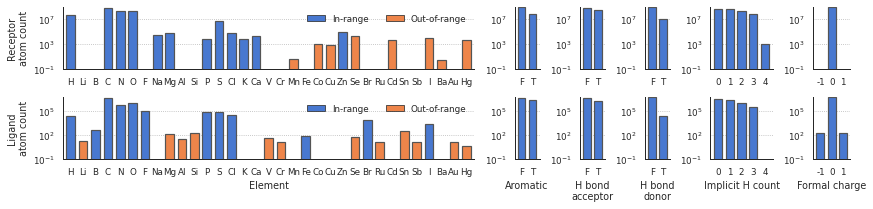

In [329]:
with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)


func_name_map = dict(
    atomic_num='Element',
    aromatic='Aromatic',
    h_acceptor='H bond\nacceptor',
    h_donor='H bond\ndonor',
    h_count='Implicit H count',
    formal_charge='Formal charge',
    hybridization='Hybridization',
)

def plot_counts(counts, ax, width=0.7, is_rec_counts=False, is_elem_counts=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by count, in decreasing order
    idx = np.argsort(labels)
    labels = labels[idx]
    counts = counts[idx]
    
    if is_elem_counts:
        
        if is_rec_counts:
            elem_range = liGAN.atom_types.AtomTyper.rec_elem_range
        else:
            elem_range = liGAN.atom_types.AtomTyper.lig_elem_range
            
        # color bars by whether they are in-range or not
        color = [colors[l not in elem_range and l != 1] for l in labels]
        
        # replace atomic number with symbol
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    else:
        color = [colors[0] for l in labels]
        
    # abbreviate boolean values
    boolean = False
    if set(labels) == {False, True}:
        labels = ['FT'[l] for l in labels]
        boolean = True

    n_values = len(counts)
    x = np.arange(n_values)
    ax.bar(x, counts, width=width, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    
    x_min = x.min() - 0.5*width - (1-width)
    x_max = x.max() + 0.5*width + (1-width)
    ax.set_xlim(x_min, x_max)
    
    if is_elem_counts:
        handles = [mpl.patches.Patch(facecolor=c, edgecolor='0.2') for c in colors[:2]]
        labels = ['In-range', 'Out-of-range']
        return ax.legend(handles, labels, frameon=False, ncol=2)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')
           
        
# make the rec and lig histograms have the same value ranges
#   and get the max counts in order to set the ylim
n_func_values = []
max_rec_count = 0
max_lig_count = 0
for f in list(rec_counts.keys())[:-1]:
    values = set(rec_counts[f].keys()) | set(lig_counts[f].keys())
    n_func_values.append(len(values))
    for v in values:
        if rec_counts[f][v] > max_rec_count:
            max_rec_count = rec_counts[f][v]
        if lig_counts[f][v] > max_lig_count:
            max_lig_count = lig_counts[f][v]

fig, axes = plt.subplots(
    2, len(funcs)-1,
    figsize=(12, 3),
    gridspec_kw=dict(width_ratios=n_func_values)
)

for i, counts in enumerate([rec_counts, lig_counts]):
    for j, func in list(enumerate(funcs))[:-1]:
        ax = axes[i][j]
        plot_counts(counts[func.__name__], ax, is_rec_counts=(i==0), is_elem_counts=(j==0))
        if i == 0:
            if j == 0:
                ax.set_ylabel('Receptor\natom count')
            ax.set_ylim([0.1, max_rec_count])
        else:
            if j == 0:
                ax.set_ylabel('Ligand\natom count')
            ax.set_ylim([0.1, max_lig_count])
            ax.set_xlabel(func_name_map[func.__name__])
        ax.set_yscale('log')
        ax.grid(axis='y', linestyle=':', color='#b0b0b0')

sns.despine(fig)
fig.tight_layout()
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/atom_properties.{ext}', bbox_inches='tight', dpi=400)

In [24]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
30	Zn	1.22	2.1
48	Cd	1.44	2.2
53	I	1.39	1.98


# 2. Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

[Table of contents](#Table-of-contents)

In [212]:
os.chdir(os.path.join(base_dir, 'bond_adding'))
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/bond_adding'

In [ ]:
add_params = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples=100000,
    typer_fns=['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol=[0, 1],
    remove_h=[0, 1],
)
len(add_params)

In [ ]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

In [ ]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

In [50]:
add_jobs = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')

In [51]:
qstat = param_search.status(job=add_jobs['job_id'])
#qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
#qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

work_dir_map = find_work_dirs()
add_jobs['work_dir'] = add_jobs.apply(find_work_dir, axis=1)
add_jobs['job_name'] = add_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_jobs['job_file'] = add_jobs.apply(lambda x: '{work_dir}/add.sh'.format(**x), axis=1)
add_jobs['stdout_file'] = add_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_jobs['stderr_file'] = add_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)

In [52]:
%%time

print('Reading stdout files')
add_jobs['stdout'] = add_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError)
)
print()

print('Reading stderr files')
add_jobs['stderr'] = add_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
)
print()

add_jobs['job_state'] = add_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(add_jobs['job_name'].unique())}
add_jobs['job_name_idx'] = add_jobs['job_name'].map(job_name_idx)
add_jobs.set_index(['job_id', 'job_name'])[['job_state', 'stdout', 'stderr']]

Reading stdout files
....................
Reading stderr files
....................
CPU times: user 22.1 ms, sys: 3.85 ms, total: 25.9 ms
Wall time: 33.4 ms


,,job_state,stdout,stderr
job_id,job_name,,,
6816993,add_oad_0_0,OK,None,None
6816994,add_oad_0_1,OK,None,None
6816995,add_oad_1_0,OK,None,None
6816996,add_oad_1_1,OK,None,None
6816997,add_oadc_0_0,OK,None,None
6816998,add_oadc_0_1,OK,None,None
6816999,add_oadc_1_0,OK,None,None
6817000,add_oadc_1_1,OK,None,None
6817001,add_on_0_0,OK,None,None


In [53]:
add_metrics = param_search.metrics(add_jobs['job_file'].unique(), metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

,example_idx
job_name,
add_oad_0_0,100000
add_oad_0_1,100000
add_oad_1_0,100000
add_oad_1_1,100000
add_oadc_0_0,100000
add_oadc_0_1,100000
add_oadc_1_0,100000
add_oadc_1_1,100000
add_oh_0_0,90903


In [54]:
# why are some REAL molecules invalid?
#   NOTE that oh did not fully complete, so the set of molecules is different
#   i.e. it is just a data artifact that it appears to have fewer invalid
plot_df = add_metrics.reset_index()
plot_df.groupby(
    ['typer_fns', 'remove_h', 'use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

lig_name               
lig_reason                    invalid valence valid molecule
typer_fns remove_h use_ob_mol                               
oad       0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444
oadc      0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444
oh        0        0                    7.786         83.117
                   1                    7.991         85.307
          1        0                    7.683         81.972
                   1                    7.991         85.307
on        0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444
onc       0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444

In [325]:
colors = get_palette(
    n_hues=5,
    n_shades=1,
    min_val=0.1,
    max_val=0.9,
)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765)]

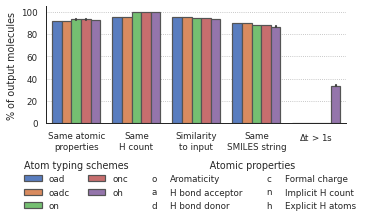

In [326]:
sns.set_context('paper')

def my_add_plot(y, *args, **kwargs):
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    ax = sns.barplot(y=y, *args, **kwargs)
    plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    return ax

typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid REAL molecules
plot_df['Same elements'] = (plot_df['elem_count_diff'] == 0)*100
plot_df['Same atomic\nproperties'] = (plot_df['prop_count_diff'] == 0)*100
plot_df['Same\nH count'] = (plot_df['n_atoms_diff'] == 0)*100
plot_df['Same\nSMILES string'] = plot_df['smi_match'].where(plot_df['lig_add_valid'])*100
plot_df['Similarity\nto input'] = (plot_df['ob_sim'])*100
plot_df['$\Delta$t > 1s'] = (plot_df['add_time'] > 1)*100

y = [
    'Same atomic\nproperties',
    'Same\nH count',
    'Similarity\nto input',
    'Same\nSMILES string',
    '$\Delta$t > 1s'
]
ylim = {k:[0, 100] for k in y}
hue = 'typer_fns'

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ].set_index(hue)[y].stack().reset_index(),
    x='level_1',
    y=0,
    hue=hue,
    n_cols=1,
    width=5,
    height=2.5,
    plot_func=my_add_plot,
    ylim=ylim,
    legend=False,
    tight=True,
)

ax = fig.axes[0]
ax.set_ylabel('% of output molecules')
ax.set_xlabel(None)
ax.grid(axis='y', linestyle=':', color='#b0b0b0')

#txt = fig.suptitle(f'Atom Typing and Bond Adding', y=1.05)

handles, labels = ax.get_legend_handles_labels()
handles = handles + [' ']
labels = labels + [' ']
handles = handles + ['o', 'a', 'd', 'c', 'n', 'h']
labels = labels + \
    ['Aromaticity', 'H bond acceptor', 'H bond donor', 'Formal charge', 'Implicit H count', 'Explicit H atoms']
lgd = ax.legend(
    handles, labels,
    loc='upper left',
    ncol=4,
    bbox_to_anchor=[-0.1,-0.25],
    title='Atom typing schemes' + 27*' ' + 'Atomic properties',
    frameon=False
)
lgd._legend_box.align = 'left'
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/bond_adding.{ext}', bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=400)

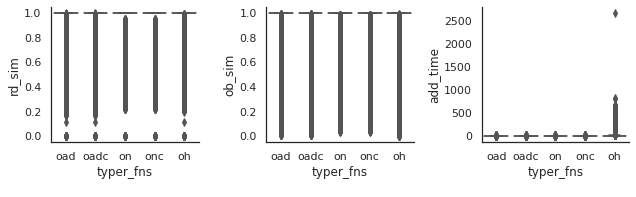

In [113]:
fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=['rd_sim', 'ob_sim', 'add_time'],
    n_cols=3,
    hue=None,
    plot_func=sns.boxplot,
)

In [ ]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

In [ ]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

# 3. Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

[Table of contents](#Table-of-contents)

In [330]:
fit_expt_dir = os.path.join(base_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting'

In [366]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)

fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    radius_fn = ['c', 'v'],
    apply_prop_conv = [0],
) + param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['onc'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)
len(fit_params)

13

In [368]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_onc-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_onc-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oh-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oh-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_onc-0.5_0/generate.sh',
 '/net/pulsar/home/ko

In [369]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

[7063727, 7063728, 7063729, 7063730, 7063731, 7063732, 7063733, 7063734, 7063735, 7063736, 7063737, 7063738, 7063739]


In [372]:
fit_jobs = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        # fix atom radius, don't shuffle data order
        [6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        # rerun covalent radius, vdw radius, and ohc without shuffling
        [7063727, 7063728, 7063729, 7063730, 7063731, 7063732, 7063733, 7063734, 7063735, 7063736, 7063737, 7063738, 7063739],
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [373]:
qstat = param_search.status(job=fit_jobs['job_id'])

fit_jobs = fit_jobs.merge(qstat, on='job_id', how='left')

work_dir_map = find_work_dirs()
fit_jobs['work_dir'] = fit_jobs.apply(find_work_dir, axis=1)
fit_jobs['job_name'] = fit_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_jobs['job_file'] = fit_jobs.apply(lambda x: '{work_dir}/generate.sh'.format(**x), axis=1)
fit_jobs['stdout_file'] = fit_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_jobs['stderr_file'] = fit_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)

job_name_idx = {j:i for i, j in enumerate(fit_jobs['job_name'].unique())}
fit_jobs['job_name_idx'] = fit_jobs['job_name'].map(job_name_idx)

In [382]:
import datetime as dt
has = lambda x: x is not None

print('Reading stdout files')
fit_jobs['stdout'] = fit_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError)
)
print()

print('Reading stderr files')
fit_jobs['stderr'] = fit_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
)
print()

fit_jobs['job_state'] = fit_jobs.apply(find_job_state, axis=1)

fit_jobs['example_idx'] = fit_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=(\d+) ', x).group(1)) if has(x) else x
)
fit_jobs['sample_idx'] = fit_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=\d+ sample_idx=(\d+) ', x).group(1)) if has(x) else np.nan
)
fit_jobs['samples_done'] = fit_jobs['example_idx']*10 + fit_jobs['sample_idx']
fit_jobs['pct_done'] = fit_jobs['samples_done']/(100000)

fit_jobs['t_left'] = fit_jobs['runtime'].map(as_timedelta) / fit_jobs['pct_done'] * (1-fit_jobs['pct_done'])
fit_jobs['t_left'] = fit_jobs['t_left'].map(lambda x: x.total_seconds() / 3600 if has(x) else x)
fit_jobs['pct_done'] *= 100

running_jobs = (fit_jobs.groupby('job_name')['job_state'].last() == 'R')
running_jobs = running_jobs[running_jobs] # drop non-running jobs

fit_jobs[
    fit_jobs['job_name'].isin(running_jobs.index) &
    True
].set_index(['job_name', 'job_id']).sort_values(['job_name_idx','job_id'])[
    ['queue', 'job_state', 'runtime', 'samples_done', 'pct_done', 't_left', 'stdout', 'stderr']
]

Reading stdout files
.........................
Reading stderr files
.........................


,,queue,job_state,runtime,samples_done,pct_done,t_left,stdout,stderr
job_name,job_id,,,,,,,,
fit_oad-c_0,7063727,dept_gpu,R,3:31,407.0,0.407,14.342153,[example_idx=40 sample_idx=7...,None
fit_oad-v_0,7063728,dept_gpu,R,3:31,305.0,0.305,19.158147,[example_idx=30 sample_idx=5...,None
fit_oadc-c_0,7063729,dept_gpu,R,3:31,397.0,0.397,14.704893,[example_idx=39 sample_idx=7...,None
fit_oadc-v_0,7063730,dept_gpu,R,3:31,269.0,0.269,21.729906,[example_idx=26 sample_idx=9...,None
fit_on-c_0,7063731,dept_gpu,R,3:31,395.0,0.395,14.779645,[example_idx=39 sample_idx=5...,None
fit_on-v_0,7063732,dept_gpu,R,3:31,268.0,0.268,21.811206,[example_idx=26 sample_idx=8...,None
fit_onc-c_0,7063733,dept_gpu,R,3:31,360.0,0.360,16.222253,[example_idx=36 sample_idx=0...,None
fit_onc-v_0,7063734,dept_gpu,R,3:31,260.0,0.260,22.484124,[example_idx=26 sample_idx=0...,None
fit_oh-c_0,7063735,dept_gpu,R,3:28,342.0,0.342,16.836309,[example_idx=34 sample_idx=2...,None


In [352]:
fit_metrics = param_search.metrics(fit_jobs['job_file'].unique(), metric_pat='(.*)metrics')
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,39,81) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_glob

,sample_idx
job_name,
fit_oad-0.5_0,100000
fit_oad-1.0_0,100000
fit_oad-1.5_0,100000
fit_oad-c_0,54530
fit_oad-c_1,53970
fit_oad-v_0,53480
fit_oad-v_1,52070
fit_oadc-0.5_0,100000
fit_oadc-1.0_0,100000


In [364]:
mol_set = set(fit_metrics[fit_metrics['job_name'] == 'fit_oad-0.5_0']['lig_name'])

for job_name, job_df in fit_metrics.groupby('job_name'):
    print(job_name, len(mol_set.intersection(set(job_df['lig_name']))))


fit_oad-0.5_0 10000
fit_oad-1.0_0 10000
fit_oad-1.5_0 10000
fit_oad-c_0 87
fit_oad-c_1 85
fit_oad-v_0 84
fit_oad-v_1 83
fit_oadc-0.5_0 10000
fit_oadc-1.0_0 10000
fit_oadc-1.5_0 10000
fit_oadc-c_0 82
fit_oadc-c_1 80
fit_oadc-v_0 80
fit_oadc-v_1 76
fit_oh-0.5_0 10000
fit_oh-1.0_0 10000
fit_oh-1.5_0 10000
fit_oh-c_0 15
fit_oh-c_1 15
fit_oh-v_0 15
fit_oh-v_1 15
fit_on-0.5_0 10000
fit_on-1.0_0 10000
fit_on-1.5_0 10000
fit_on-c_0 66
fit_on-c_1 65
fit_on-v_0 55
fit_on-v_1 65


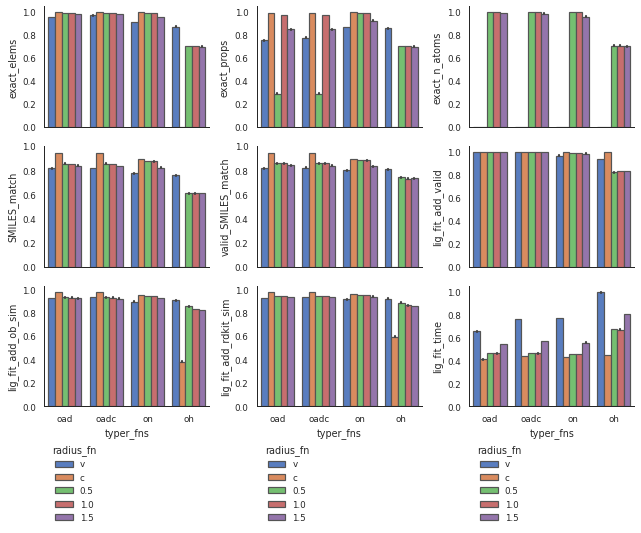

In [353]:
def my_fit_plot(y, *args, **kwargs):
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    ax = sns.barplot(y=y, *args, **kwargs)
    plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    return ax

plot_df = fit_metrics.reset_index()

# find that set of molecules that were fit successfully with each setting
fit_mols = set()
for j in plot_df['job_name'].unique():


plot_df = plot_df[plot_df['lig_valid']] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_fit_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)

In [ ]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
ax = plot_df.hist('lig_radius', bins=25)[0,0]
ax.set_xlim(0, 23.5)

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
y = 'lig_fit_n_atoms_diff'
ax = plot_df.plot(x='lig_radius', y=y, kind='scatter', alpha=0.01, s=10)
ylim = ax.get_ylim()
ax.vlines(23.5/2, *ax.get_ylim(), 'k', linestyle='--')
ax.vlines(23.5/2*(3**0.5), *ax.get_ylim(), 'k', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlim(0, 23.5)
plot_df[['lig_radius', y]].corr()

# 4. Training experiment

Train generative models to produce atomic density grids and periodically test atom fitting performance.

[Table of contents](#Table-of-contents)

In [383]:
train_expt_dir = os.path.join(base_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

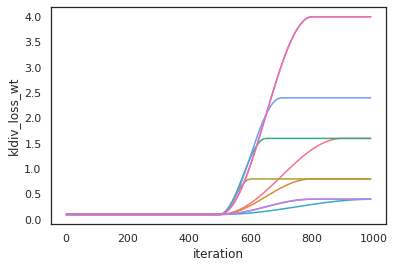

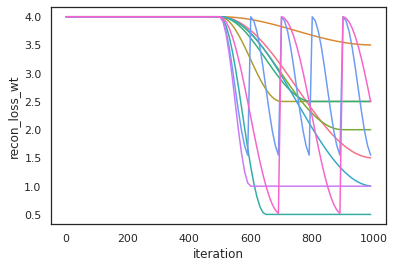

In [4]:
import liGAN
import random, torch

sns.set_palette('husl', 10)

def plot_ls(ylabel, start_wt, type, period, end_wt):
    f, _ = liGAN.loss_fns.get_loss_schedule(
        start_wt=start_wt,
        end_wt=end_wt,
        start_iter=500,
        period=period,
        type=type
    )
    x = torch.arange(1, 1000, 10)
    y = [f(x_) for x_ in x]
    plt.plot(x, y)
    plt.ylabel(ylabel)
    plt.xlabel('iteration')

plt.figure()
for i in range(10):
    plot_ls(
        'kldiv_loss_wt', 0.1,
        random.choice('ddcr'),
        random.choice([100, 150, 200, 250, 300, 400, 500]),
        random.choice([0.2, 0.4, 0.8, 1.6, 2.4, 3.2, 4.0])
    )
plt.figure()
for i in range(10):
    plot_ls(
        'recon_loss_wt', 4.0,
        random.choice('ddcr'),
        random.choice([100, 150, 200, 250, 300, 400, 500]),
        random.choice([3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5])
    )

In [5]:
import param_search

base_params = param_search.ParamSpace( # train6 - prior improvement
    
    # data params
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    batch_size=8,
    
    # typer params
    typer_fns='oadc',
    use_rec_elems=True,
    radius_fn=1.0,
    
    # gen model params
    gen_n_filters=28,
    gen_init_conv_pool=0,
    gen_n_levels=4,
    gen_conv_per_level=4,
    gen_spectral_norm=1,
    n_latent=128,
    skip_connect=True,
    block_type='r',
    growth_rate=0,
    width_factor=2,
    bn_factor=0,
    
    # loss fn params
    kldiv_loss_start_wt=0.1,
    recon_loss_start_wt=4.0,
    steric_loss_start_wt=1.0,
    gan_loss_start_wt=0.0,

    # optimizer params
    optim_type=['RMSprop'],
    gen_lr=1e-5,
    gen_grad_clip=5000,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    learn_recon_var=[0, 1],
    
    # other stuff
    group_name='6',
    gen_k_iter=600,
    sbatch_line='#SBATCH -C M12',
    
    # no GAN disc
    disc_n_filters=0,
    disc_init_conv_pool=0,
    disc_n_levels=0,
    disc_conv_per_level=0,
    n_disc_train_iters=0,
    disc_lr=0.0,

    # stage2 VAE params
    model_type='CVAE2',
    prior_n_layers=[0,1,2],
    random_seed=range(100),
    kldiv2_loss_start_wt=[0.5, 1.0, 2.0, 4.0],
    recon2_loss_start_wt=[0.5, 1.0, 2.0, 4.0],
)

sched0_params = param_search.ParamSpace( # no loss wt schedule
    start_iter=450000,
    kldiv_loss_end_wt=0.1,
    kldiv_loss_period=0,
    kldiv_loss_sched_type='n',
    recon_loss_end_wt=4.0,
    recon_loss_period=0,
    recon_loss_sched_type='n'
)
sched1_params = param_search.ParamSpace( # increase kl div loss wt
    start_iter=450000,
    kldiv_loss_end_wt=[0.2, 0.4, 0.8, 1.6, 2.4, 3.2, 4.0],
    kldiv_loss_period=[100, 150, 200, 250, 300, 400, 500],
    kldiv_loss_sched_type=['d', 'd', 'c', 'r'],
    recon_loss_end_wt=4.0,
    recon_loss_period=0,
    recon_loss_sched_type='n'
)
sched2_params = param_search.ParamSpace( # decrease recon loss wt
    start_iter=450000,
    kldiv_loss_end_wt=0.1,
    kldiv_loss_period=0,
    kldiv_loss_sched_type='n',
    recon_loss_end_wt=[3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5],
    recon_loss_period=[100, 150, 200, 250, 300, 400, 500],
    recon_loss_sched_type=['d', 'd', 'c', 'r']
)

# evenly sample each subspace
train_params = base_params * (
    len(sched1_params)*len(sched2_params)*sched0_params + 
    len(sched0_params)*len(sched2_params)*sched1_params +
    len(sched0_params)*len(sched1_params)*sched2_params
)

name_format = 'train{group_name}_{model_type}_{learn_recon_var}_' \
    'p{prior_n_layers}_{kldiv2_loss_start_wt}_{recon2_loss_start_wt}_' \
    'k{kldiv_loss_period}_{kldiv_loss_sched_type}_{kldiv_loss_end_wt}_' \
    'r{recon_loss_period}_{recon_loss_sched_type}_{recon_loss_end_wt}_' \
    '{random_seed}'

len(train_params)

1106380800

In [715]:
import random
random.seed(0)
np.random.seed(0)

sampled_params = train_params.sample(100, replace=False)

for p in sampled_params:
    name = name_format.format(**p)
    print(name)

print(len(sampled_params))

train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8
train6_CVAE2_1_p0_2.0_0.5_k0_n_0.1_r100_d_0.5_2
train6_CVAE2_1_p1_4.0_1.0_k0_n_0.1_r300_c_2.5_93
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r0_n_4.0_89
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26
train6_CVAE2_0_p1_0.5_4.0_k0_n_0.1_r0_n_4.0_43
train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r250_c_1.5_46
train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r0_n_4.0_49
train6_CVAE2_0_p0_4.0_2.0_k500_d_4.0_r0_n_4.0_78
train6_CVAE2_0_p0_0.5_0.5_k0_n_0.1_r0_n_4.0_45
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47
train6_CVAE2_1_p2_0.5_4.0_k0_n_0.1_r150_c_3.5_81
train6_CVAE2_1_p2_1.0_0.5_k500_c_3.2_r0_n_4.0_66
train6_CVAE2_1_p2_2.0_1.0_k250_r_0.2_r0_n_4.0_89
train6_CVAE2_0_p2_4.0_2.0_k0_n_0.1_r100_d_3.5_58
train6_CVAE2_0_p1_0.5_0.5_k250_r_4.0_r0_n_4.0_70
train6_CVAE2_1_p2_0.5_4.0_k0_n_0.1_r300_c_1.0_84
train6_CVAE2_0_p1_1.0_1.0_k0_n_0.1_r0_n_4.0_1
train6_CVAE2_0_p1_1.0_2.0_k0_n_0.1_r300_r_2.5_39
train6_CVAE2_1_p1_4.0_0.5_k500_c_0.2_r0_n_4.0_63
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.

In [716]:
for template_file in [
    'gen_poster.config', 'gen_poster.sh',
    'gen_prior.config', 'gen_prior.sh',
    'gen_poster2.config', 'gen_poster2.sh',
    'gen_prior2.config', 'gen_prior2.sh',
    'train.config', 'train.sh'
]:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=sampled_params,
    )

train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p0_2.0_0.5_k0_n_0.1_r100_d_0.5_2/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p1_4.0_1.0_k0_n_0.1_r300_c_2.5_93/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r0_n_4.0_89/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_0.5_4.0_k0_n_0.1_r0_n_4.0_43/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r250_c_1.5_46/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r0_n_4.0_49/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/traini

In [358]:
job_ids = param_search.submit(train_job_files)

In [618]:
train_jobs = pd.DataFrame(dict(
    job_id=[
        # these first jobs were full-scale, had major performance issues, didn't have separate receptor element ranges
        #[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],

        # train0 CVAEs, CVAEGANs, and CGANs, first submit
        [6818214, 6818215, 6818216, 6818217, 6818218, 6818219, 6818220, 6818221, 6818222, 6818223, 6818224, 6818225, 6818226, 6818227, 6818228, 6818229, 6818230, 6818231, 6818232, 6818233, 6818234, 6818235, 6818236, 6818237, 6818238, 6818239, 6818240, 6818241, 6818242, 6818243],

        # train1 CVAEs, CVAEGANs, and CGANs, first submit (held most CVAEGANs and CGANs to allow full data jobs)
        [6820019, 6820020, 6820021, 6820022, 6820023, 6820024, 6820025, 6820026, 6820027, 6820028, 6820029, 6820030, 6820031, 6820032, 6820033, 6820034, 6820035, 6820036, 6820037, 6820038, 6820039, 6820040, 6820041, 6820042, 6820043, 6820044, 6820045, 6820046, 6820047, 6820048, 6820049, 6820050, 6820051, 6820052, 6820053, 6820054, 6820055, 6820056, 6820057, 6820058, 6820059, 6820060, 6820061, 6820062, 6820063, 6820064, 6820065, 6820066, 6820067, 6820068, 6820069, 6820070, 6820071, 6820072, 6820073, 6820074, 6820075, 6820076, 6820077, 6820078, 6820079, 6820080, 6820081, 6820082, 6820083, 6820084, 6820085, 6820086, 6820087, 6820088, 6820089, 6820090, 6820091, 6820092, 6820093, 6820094, 6820095, 6820096, 6820097, 6820098, 6820099, 6820100, 6820101, 6820102, 6820103, 6820104, 6820105, 6820106, 6820107, 6820108],

        # train1 models that got CUDA error on g005, resubmit with -x g005
        [6820859, 6820860, 6820861, 6820862, 6820863, 6820864, 6820865, 6820866, 6820867, 6820868, 6820869, 6820870, 6820871, 6820872, 6820873, 6820874, 6820875, 6820876, 6820877, 6820878, 6820879, 6820880, 6820881, 6820882, 6820883, 6820884, 6820885, 6820886, 6820887, 6820888, 6820889, 6820890, 6820891, 6820892, 6820893, 6820894, 6820895, 6820896, 6820897, 6820898, 6820899, 6820900, 6820901, 6820902, 6820903, 6820904, 6820905, 6820906, 6820907, 6820908, 6820909, 6820910, 6820911, 6820912, 6820913, 6820914, 6820915, 6820916, 6820917, 6820918, 6820919, 6820920, 6820921, 6820922, 6820923, 6820924, 6820925, 6820926, 6820927, 6820928],

        # train2 CVAEs on full dataset, first submit
        [6820935, 6820936, 6820937, 6820938, 6820939, 6820940, 6820941, 6820942, 6820943, 6820944, 6820945, 6820946, 6820947, 6820948, 6820949, 6820950, 6820951, 6820952, 6820953, 6820954, 6820955, 6820956, 6820957, 6820958],

        # train1 CVAEs with gen_lr=1e-5 that hit 100k, resubmit to train to 200k- errors loading state
        #[6831137, 6831138, 6831139, 6831140, 6831141, 6831142, 6831143],
        
        # train1- same jobs as last submit, but fixed loading solver state
        [6834544, 6834545, 6834546, 6834547, 6834548, 6834549],

        # BUG STARTS HERE- switched from lig elems to rec elems (for rec AND lig)
        # train2- resubmit all jobs, training to 200k- these did not have continue set, so they started from 0
        #[6837351, 6837352, 6837353, 6837354, 6837355, 6837356, 6837357, 6837358, 6837359, 6837360, 6837361, 6837362, 6837363, 6837364, 6837365, 6837366, 6837367, 6837368, 6837369, 6837370, 6837371, 6837372, 6837373, 6837374],

        # train2- let's try that again
        [6837376, 6837377, 6837378, 6837379, 6837380, 6837381, 6837382, 6837383, 6837384, 6837385, 6837386, 6837387, 6837388, 6837389, 6837390, 6837391, 6837392, 6837393, 6837394, 6837395, 6837396, 6837397, 6837398, 6837399],

        # train1- released jobs tried to continue from iter 0, but no metrics file was found. add try-except to ignore this
        [6837497, 6837498, 6837499, 6837500, 6837501, 6837502, 6837503, 6837504, 6837505, 6837506, 6837507, 6837508, 6837509, 6837510, 6837511, 6837512, 6837513, 6837514, 6837515, 6837516, 6837517, 6837518, 6837519, 6837520, 6837521, 6837522, 6837523, 6837524, 6837525, 6837526, 6837527, 6837528, 6837529, 6837530, 6837531, 6837532, 6837533, 6837534, 6837535, 6837536, 6837537, 6837538, 6837539, 6837540, 6837541, 6837542, 6837543, 6837544, 6837545, 6837546, 6837547, 6837548],

        # train2- train full data CVAEs to 300k
        [6837556, 6837557, 6837558, 6837559, 6837560, 6837561, 6837562, 6837563, 6837564, 6837565, 6837566, 6837567, 6837568, 6837569, 6837570, 6837571, 6837572, 6837573, 6837574, 6837575, 6837576, 6837577, 6837578, 6837579],

        # train2- manually resubmitted with fixed SBATCH -c M16 due to cuda oom (expecting more...)
        [6837581, 6837582],
        
        # train1- resubmit best lrs combos of each model (CVAEs to 300k, others to 200k)
        [6845980, 6845981, 6845982, 6845983, 6845984, 6845985, 6845986, 6845987, 6845988, 6845989, 6845990, 6845991, 6845992, 6845993, 6845994, 6845995, 6845996, 6845997],

        # train2- manually resubmitted job, got unable to allocate bytes on torch.save
        [6845999],
        
        # BUG FIXED HERE- switched to rec elems for rec, lig elems for lig
        # train1- resubmit best of each model type to train out the bug
        [6853415, 6853416, 6853417, 6853418, 6853419, 6853420, 6853421, 6853422, 6853423, 6853424, 6853425, 6853426, 6853427, 6853428, 6853429, 6853430, 6853431, 6853432],
        # train2- resubmit best lr combo models to train out the bug
        [6853433, 6853434, 6853435, 6853436, 6853437, 6853438, 6853439, 6853440],
        
        # train3- random search space seed 0 (held)
        [6879506, 6879509, 6879511, 6879513, 6879514, 6879515, 6879516, 6879517, 6879518, 6879519, 6879520, 6879521, 6879522, 6879523, 6879524, 6879525, 6879526, 6879527, 6879528, 6879529, 6879530, 6879531, 6879532, 6879533, 6879534, 6879535, 6879536, 6879537, 6879538, 6879539, 6879541, 6879542, 6879544, 6879546, 6879551, 6879553, 6879555, 6879560, 6879561, 6879564, 6879567, 6879569, 6879571, 6879572, 6879573, 6879575, 6879576, 6879577, 6879578, 6879579, 6879580, 6879581, 6879582, 6879583, 6879584, 6879585, 6879586, 6879587, 6879588, 6879589, 6879590, 6879591, 6879592, 6879593, 6879594, 6879595, 6879596, 6879599, 6879602, 6879603, 6879605, 6879608, 6879613, 6879617, 6879619, 6879622, 6879624, 6879626, 6879627, 6879628, 6879629, 6879631, 6879632, 6879633, 6879634, 6879635, 6879636, 6879637, 6879638, 6879639, 6879640, 6879641, 6879642, 6879643, 6879644, 6879645, 6879646, 6879647, 6879648, 6879649, 6879650, 6879651, 6879652, 6879653, 6879654, 6879655, 6879656, 6879665, 6879666, 6879667, 6879668, 6879669, 6879670, 6879671, 6879672, 6879673, 6879674, 6879675, 6879676, 6879677, 6879678, 6879679, 6879680, 6879681, 6879682, 6879683, 6879684, 6879685, 6879686, 6879687, 6879688, 6879689, 6879702, 6879703, 6879704, 6879705, 6879706, 6879707, 6879708, 6879709, 6879710, 6879711, 6879712, 6879713, 6879714, 6879715, 6879716, 6879717, 6879718, 6879719, 6879720, 6879721, 6879722, 6879723, 6879724, 6879725, 6879752, 6879753, 6879754, 6879755, 6879756, 6879757, 6879758, 6879759, 6879760, 6879761, 6879762, 6879763, 6879764, 6879765, 6879766, 6879767, 6879768, 6879769, 6879770, 6879771, 6879772, 6879783, 6879784, 6879785, 6879786, 6879787, 6879788, 6879789, 6879790, 6879791, 6879792, 6879793, 6879794, 6879795, 6879796, 6879797, 6879798, 6879799, 6879800, 6879801, 6879802, 6879803, 6879804, 6879805, 6879806, 6879807, 6879820, 6879821, 6879822, 6879823, 6879824, 6879825, 6879826, 6879827, 6879828, 6879829, 6879830, 6879831, 6879832, 6879833, 6879834, 6879835, 6879836, 6879837, 6879838, 6879839, 6879840, 6879841, 6879842, 6879843, 6879844, 6879865, 6879866, 6879867, 6879868, 6879869, 6879870, 6879871, 6879872, 6879873, 6879874, 6879875, 6879876, 6879877, 6879878, 6879879, 6879880, 6879881, 6879882, 6879883, 6879884, 6879885, 6879886, 6879887, 6879888, 6879897, 6879898, 6879899, 6879900, 6879901, 6879902, 6879903, 6879904, 6879905, 6879906, 6879907, 6879908, 6879909, 6879910, 6879911, 6879912, 6879913, 6879914, 6879915, 6879916, 6879917, 6879918, 6879919, 6879920, 6879921, 6879939, 6879940, 6879941, 6879942, 6879943, 6879944, 6879945, 6879946, 6879947, 6879948, 6879949, 6879950, 6879951, 6879952, 6879953, 6879954, 6879955, 6879956, 6879957, 6879958, 6879959, 6879960, 6879984, 6879985],

        # train3- fix unbound loss_gen error and resubmit (jobs with disc_train_iters=1) (released)
        [6883168, 6883169, 6883170, 6883171, 6883172, 6883173, 6883174, 6883175, 6883176, 6883177, 6883178, 6883179],
        
        # train3- resubmit CUDA oom models with -C M12 (released)
        [6883206, 6883207, 6883208, 6883209],
        
        # train3- jobs that already reached < 150 test recon loss by 100k
        [6889371, 6889372, 6889373, 6889374, 6889375, 6889376, 6889377],
        
        # train3- resubmitted jobs with under < 200 test recon loss (same models as prev to 300k plus some new to 200k)
        [6890657, 6890658, 6890659, 6890660, 6890661, 6890662, 6890663, 6890664, 6890665, 6890666, 6890667, 6890668, 6890669, 6890670, 6890671, 6890672],

        # train3- resubmit CUDA oom models with -C M16, then cancel ones already running (reason=dependency)
        [6890882, 6890883, 6890884, 6890885, 6890886, 6890887, 6890888, 6890889, 6890890, 6890891, 6890892, 6890893, 6890894, 6890895, 6890896, 6890897, 6890898, 6890899, 6890900, 6890901, 6890902, 6890903, 6890904, 6890905, 6890906],

        # train4 - submit all with clamped steric loss
        [6922074, 6922075, 6922076, 6922077, 6922078, 6922079, 6922080, 6922081, 6922082, 6922083, 6922084, 6922085, 6922086, 6922087, 6922088, 6922089, 6922090, 6922091, 6922092, 6922093, 6922094, 6922095, 6922096, 6922097, 6922098, 6922099, 6922100, 6922101, 6922102, 6922103, 6922104, 6922105, 6922106, 6922107, 6922108, 6922109, 6922110, 6922111, 6922112, 6922113, 6922114, 6922115, 6922116, 6922117, 6922118, 6922119, 6922120, 6922121, 6922122, 6922123, 6922124, 6922125, 6922126, 6922127, 6922128, 6922129, 6922130, 6922131, 6922132, 6922133, 6922134, 6922135, 6922136, 6922137, 6922138, 6922139, 6922140, 6922141, 6922142, 6922143, 6922144, 6922145, 6922146, 6922147, 6922148, 6922149, 6922150, 6922151, 6922152, 6922153, 6922154, 6922155, 6922156, 6922157, 6922158, 6922159, 6922160, 6922161, 6922162, 6922163, 6922164, 6922165, 6922166, 6922167, 6922168, 6922169, 6922170, 6922171, 6922172, 6922173],

        # train4- resubmit better-than-train3 jobs that errored out
        [6970651, 6970652, 6970653, 6970654, 6970655, 6970656, 6970657, 6970658, 6970659, 6970660],
        
        # train4- resubmit all cuda oom jobs with more requested GPU memory
        [6970667, 6970668, 6970669, 6970670, 6970671, 6970672, 6970673, 6970674, 6970675, 6970676, 6970677, 6970678, 6970679, 6970680, 6970681, 6970682, 6970683, 6970684, 6970685],

        # train5 - submit all in order of decreasing estimated GPU memory
        [6971032, 6971033, 6971034, 6971035, 6971036, 6971037, 6971038, 6971039, 6971040, 6971041, 6971042, 6971043, 6971044, 6971045, 6971046, 6971047, 6971048, 6971049, 6971050, 6971051, 6971052, 6971053, 6971054, 6971055, 6971056, 6971057, 6971058, 6971059, 6971060, 6971061, 6971062, 6971063, 6971064, 6971065, 6971066, 6971067, 6971068, 6971069, 6971070, 6971071, 6971072, 6971073, 6971074, 6971075, 6971076, 6971077, 6971078, 6971079, 6971080, 6971081, 6971082, 6971083, 6971084, 6971085, 6971086, 6971087, 6971088, 6971089, 6971090, 6971091, 6971092, 6971093, 6971094, 6971095, 6971096, 6971097, 6971098, 6971099, 6971100, 6971101, 6971102, 6971103, 6971104, 6971105, 6971106, 6971107, 6971108, 6971109, 6971110, 6971111, 6971112, 6971113, 6971114, 6971115, 6971116, 6971117, 6971118, 6971119, 6971120, 6971121, 6971122, 6971123, 6971124, 6971125, 6971126, 6971127, 6971128, 6971129, 6971130, 6971131],

        # train5 - resubmit OOM jobs with batch size = 4 and no SBATCH line
        [6971166, 6971167, 6971168, 6971169, 6971170, 6971171, 6971172, 6971173, 6971174, 6971175, 6971176, 6971177, 6971178, 6971179, 6971180, 6971181, 6971182, 6971183, 6971184, 6971185, 6971186, 6971187, 6971188, 6971189, 6971190, 6971191, 6971192, 6971193, 6971194, 6971195, 6971196, 6971197, 6971198, 6971199],

        # train4 and train5 - resubmit promising jobs that are not currently running
        [6971523, 6971524, 6971525, 6971526, 6971527, 6971528, 6971529, 6971530, 6971531, 6971532, 6971533, 6971534],
        [6971535, 6971536, 6971537, 6971538, 6971539, 6971540, 6971541, 6971542, 6971543, 6971544, 6971545, 6971546, 6971547, 6971548, 6971549, 6971550, 6971551, 6971552, 6971553, 6971554, 6971555, 6971556, 6971557, 6971558, 6971559, 6971560, 6971561, 6971562, 6971563, 6971564, 6971565, 6971566],
        
        # train6- first submit with no mem request, few gpus available, most failed with cuda oom
        [6987997, 6987998, 6987999, 6988000, 6988001, 6988002, 6988003, 6988004, 6988005, 6988006, 6988007, 6988008, 6988009, 6988010, 6988011, 6988012, 6988013, 6988014, 6988015, 6988016, 6988017, 6988018, 6988019, 6988020, 6988021, 6988022, 6988023, 6988024, 6988025, 6988026, 6988027, 6988028, 6988029, 6988030, 6988031, 6988032, 6988033, 6988034, 6988035, 6988036, 6988037, 6988038, 6988039, 6988040, 6988041, 6988042, 6988043, 6988044, 6988045, 6988046, 6988047, 6988048, 6988049, 6988050, 6988051, 6988052, 6988053, 6988054, 6988055, 6988056, 6988057, 6988058, 6988059, 6988060, 6988061, 6988062, 6988063, 6988064, 6988065, 6988066, 6988067, 6988068, 6988069, 6988070, 6988071, 6988072, 6988073, 6988074, 6988075, 6988076, 6988077, 6988078, 6988079, 6988080, 6988081, 6988082, 6988083, 6988084, 6988085, 6988086, 6988087, 6988088, 6988089, 6988090, 6988091, 6988092, 6988093, 6988094, 6988095, 6988096],
        
        # train6- resubmit with M12 and fix solver state files after name format change
        [6988124, 6988125, 6988126, 6988127, 6988128, 6988129, 6988130, 6988131, 6988132, 6988133, 6988134, 6988135, 6988136, 6988137, 6988138, 6988139, 6988140, 6988141, 6988142, 6988143, 6988144, 6988145, 6988146, 6988147, 6988148, 6988149, 6988150, 6988151, 6988152, 6988153, 6988154, 6988155, 6988156, 6988157, 6988158, 6988159, 6988160, 6988161, 6988162, 6988163, 6988164, 6988165, 6988166, 6988167, 6988168, 6988169, 6988170, 6988171, 6988172, 6988173, 6988174, 6988175, 6988176, 6988177, 6988178, 6988179, 6988180, 6988181, 6988182, 6988183, 6988184, 6988185, 6988186, 6988187, 6988188, 6988189, 6988190, 6988191, 6988192, 6988193, 6988194, 6988195, 6988196, 6988197, 6988198, 6988199, 6988200, 6988201, 6988202, 6988203, 6988204, 6988205, 6988206, 6988207, 6988208, 6988209, 6988210, 6988211, 6988212, 6988213, 6988214, 6988215, 6988216, 6988217, 6988218, 6988219, 6988220, 6988221, 6988222, 6988223],

        # train6- cancel and resubmit me with revised vae2 loss weights
        [6988235, 6988236, 6988237, 6988238, 6988239, 6988240, 6988241, 6988242, 6988243, 6988244, 6988245, 6988246, 6988247, 6988248, 6988249, 6988250, 6988251, 6988252, 6988253, 6988254, 6988255, 6988256, 6988257, 6988258, 6988259, 6988260, 6988261, 6988262, 6988263, 6988264, 6988265, 6988266, 6988267, 6988268, 6988269, 6988270, 6988271, 6988272, 6988273, 6988274, 6988275, 6988276, 6988277, 6988278, 6988279, 6988280, 6988281, 6988282, 6988283, 6988284, 6988285, 6988286, 6988287, 6988288, 6988289, 6988290, 6988291, 6988292, 6988293, 6988294, 6988295, 6988296, 6988297, 6988298, 6988299, 6988300, 6988301, 6988302, 6988303, 6988304, 6988305, 6988306, 6988307, 6988308, 6988309, 6988310, 6988311, 6988312, 6988313, 6988314, 6988315, 6988316, 6988317, 6988318, 6988319, 6988320, 6988321, 6988322, 6988323, 6988324, 6988325, 6988326, 6988327, 6988328, 6988329, 6988330, 6988331, 6988332, 6988333, 6988334],
        
        # train6- accidentally cancelled all jobs, resumbit ones with increased prior n_atoms
        [7017136, 7017139, 7017141, 7017142, 7017146, 7017147, 7017148, 7017149, 7017150, 7017151, 7017152, 7017153, 7017154, 7017155, 7017156, 7017157, 7017158, 7017159, 7017160, 7017161, 6988316, 6988317, 6988318, 6988319, 6988320, 6988321, 6988322, 6988323, 6988324, 6988325, 6988326, 6988327, 6988328, 6988329, 6988330, 6988331, 6988332, 6988333, 6988334, 7017120, 7017121, 7017122, 7017123, 7017124, 7017125, 7017126, 7017127, 7017128, 7017129, 7017130, 7017131, 7017133]
    ],
    group_name=[0,1,1,2,1,2,1,2,2,1,2,1,2,3,3,3,3,3,3,4,4,4,5,5,4,5,6,6,6,6]
)).explode('job_id')

In [619]:
%%time
import param_search
param_search.job_queues.verbose = False
from collections import defaultdict

print('Getting queue status')
qstat = param_search.status(job=train_jobs['job_id'])

if qstat['job_id'].dtype in {str, object}:
    qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

print('Merging data frames')
train_jobs = train_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
train_jobs['work_dir'] = train_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
train_jobs['job_name'] = train_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_jobs['job_file'] = train_jobs.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_jobs['stdout_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_jobs['stderr_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_jobs['metrics_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_name}.train_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 667 ms, sys: 160 ms, total: 827 ms
Wall time: 1.12 s


In [620]:
# read in ALL training params
train_jobs = train_jobs[
    ~train_jobs['work_dir'].isnull()
].groupby(['job_name']).last().reset_index()
train_params = train_jobs['job_file'].apply(param_search.params.read_params, line_start='# ')
train_params = pd.DataFrame(train_params.tolist()).set_index('job_name')
train_params['out_prefix'] = train_params.index.map(lambda x: '{}/{}'.format(x, x))
train_params['last_iter'] = train_params['out_prefix'].map(catch_exc(liGAN.training.find_last_iter, FileNotFoundError))
train_params

,random_seed,data_root,train_file,test_file,model_type,typer_fns,radius_fn,n_latent,gen_spectral_norm,optim_type,gen_lr,disc_lr,gen_grad_clip,disc_grad_clip,n_gen_train_iters,n_disc_train_iters,group_name,sbatch_line,gen_iteration,gen_prior,use_rec_elems,gen_init_conv_pool,gen_conv_per_level,gen_block_type,gen_n_filters,kldiv_loss_wt,recon_loss_wt,disc_init_conv_pool,disc_conv_per_level,disc_block_type,disc_n_filters,gan_loss_wt,batch_size,bn_factor,skip_connect,steric_loss_wt,gen_k_iter,gen_n_levels,block_type,growth_rate,width_factor,disc_n_levels,kldiv_loss_start_wt,recon_loss_start_wt,steric_loss_start_wt,gan_loss_start_wt,learn_recon_var,prior_n_layers,kldiv2_loss_start_wt,recon2_loss_start_wt,start_iter,kldiv_loss_end_wt,kldiv_loss_period,kldiv_loss_sched_type,recon_loss_end_wt,recon_loss_period,recon_loss_sched_type,out_prefix,last_iter
job_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
train0_CGAN_on-1.0_1.0e-05_1.0e-04_0,0,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,CGAN,on,1.0,128,0,RMSprop,0.00001,0.00010,0,0,1,2,0,,80000.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train0_CGAN_on-1.0_1.0e-05_1.0e-04_0/train0_CGAN_on-1.0_1.0e-05_1.0e-04_0,100000.0
train0_CGAN_on-1.0_1.0e-05_1.0e-04_1,1,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,CGAN,on,1.0,128,0,RMSprop,0.00001,0.00010,0,0,1,2,0,,80000.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train0_CGAN_on-1.0_1.0e-05_1.0e-04_1/train0_CGAN_on-1.0_1.0e-05_1.0e-04_1,100000.0
train0_CGAN_on-1.0_1.0e-05_1.0e-04_2,2,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,CGAN,on,1.0,128,0,RMSprop,0.00001,0.00010,0,0,1,2,0,,80000.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train0_CGAN_on-1.0_1.0e-05_1.0e-04_2/train0_CGAN_on-1.0_1.0e-05_1.0e-04_2,100000.0
train0_CGAN_on-1.0_1.0e-05_1.0e-05_0,0,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,CGAN,on,1.0,128,0,RMSprop,0.00001,0.00001,0,0,1,2,0,,80000.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train0_CGAN_on-1.0_1.0e-05_1.0e-05_0/train0_CGAN_on-1.0_1.0e-05_1.0e-05_0,100000.0
train0_CGAN_on-1.0_1.0e-05_1.0e-05_1,1,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_head1.types,CGAN,on,1.0,128,0,RMSprop,0.00001,0.00001,0,0,1,2,0,,80000.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train0_CGAN_on-1.0_1.0e-05_1.0e-05_1/train0_CGAN_on-1.0_1.0e-05_1.0e-05_1,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8,8,/net/pulsar/home/koes/paf46_sha

In [621]:
pd.set_option('display.max_columns', 100)
has = lambda x: not pd.isnull(x)

train_param_path = [
    'train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
    'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',   # reduce latent space size, use receptor elements
    'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0', # switch to acceptor/donor/charge atom typer
    'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93', # < kldiv wt, > recon wt
    'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34', # spectral norm, < kldiv wt, skip connect
    'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45', # deeper/narrower, resnet, > recon wt, steric loss
    'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65', # CVAE1- > kldiv wt w/ loss schedule, gradient clipping
    'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8', # CVAE2- stage 2 VAE, learn recon variance
]
ignore_cols = {'sbatch_line', 'gen_iteration', 'group_name', 'random_seed', 'batch_size', 'gen_k_iter'}

default_train_params = dict(
    gen_init_conv_pool=0,
    gen_n_levels=4,
    gen_conv_per_level=3,
    gen_block_type='c',
    gen_n_filters=32,
    #kldiv_loss_wt=1,
    #recon_loss_wt=1,
    #gan_loss_wt=0,
    disc_init_conv_pool=0,
    disc_block_type='c',
    disc_conv_per_level=0,
    disc_n_levels=0,
    disc_n_filters=0,
    bn_factor=0,
    skip_connect=False,
    steric_loss_wt=0,
    block_type='c',
    growth_rate=0,
    width_factor=2,
)

for k, v in default_train_params.items():
    train_params[k] = train_params[k].fillna(v)

def param_diff(param_path):
    row1 = train_params.loc[param_path[0]]
    row2 = train_params.loc[param_path[-1]]
    diff_cols = [
        c for c in train_params if (row2[c] != row1[c] and (has(row2[c]) or has(row1[c]))) and c not in ignore_cols
    ]
    return train_params.loc[param_path][diff_cols]

train_jobs = train_jobs[
    train_jobs['job_name'].isin(train_param_path)
]

param_diff(train_param_path)

,model_type,typer_fns,n_latent,gen_spectral_norm,gen_grad_clip,n_disc_train_iters,use_rec_elems,gen_conv_per_level,gen_n_filters,skip_connect,block_type,kldiv_loss_start_wt,recon_loss_start_wt,steric_loss_start_wt,gan_loss_start_wt,learn_recon_var,prior_n_layers,kldiv2_loss_start_wt,recon2_loss_start_wt,start_iter,kldiv_loss_end_wt,kldiv_loss_period,kldiv_loss_sched_type,recon_loss_end_wt,recon_loss_period,recon_loss_sched_type,out_prefix,last_iter
job_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0,CVAE,on,1024,0,0,2,False,3.0,32.0,False,c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0/train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0,390000.0
train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0,CVAE,on,128,0,0,2,True,3.0,32.0,False,c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0/train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0,400000.0
train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0,CVAE,oadc,128,0,0,2,True,3.0,32.0,False,c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0/train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0,400000.0
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93,CVAE,oadc,128,0,0,0,True,3.0,32.0,False,c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93/train3_CVAE_oadc_0_3_c_...,400000.0
train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34,CVAE,oadc,128,1,0,0,True,3.0,32.0,True,c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34/train4_CVAE_c200_G3243_1.0e-05_D...,280000.0
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45,CVAE,oadc,128,1,0,0,True,4.0,28.0,True,r,0.1,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D...,590000.0
train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65,CVAE2,oadc,128,1,5000,0,True,4.0,28.0,True,r,0.1,4.0,1.0,0.0,0.0,0.0,4.0,4.0,450000.0,1.6,200.0,r,4.0,0.0,n,train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65/train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65,850000.0
train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8,CVAE2,oadc,128,1,5000,0,True,4.0,28.0,True,r,0.1,4.0,1.0,0.0,1.0,2.0,1.0,1.0,450000.0,0.2,100.0,c,4.0,0.0,n,train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8,850000.0


In [622]:
%%time

print('Reading stdout files (train)')
train_jobs['stdout_train'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(test.*?|train model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stdout files (test)')
train_jobs['stdout_test'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(train.*?|test model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stderr files')
train_jobs['stderr'] = train_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    ignore_pat=None,
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
train_jobs['job_state'] = train_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(train_jobs['job_name'].unique())}
train_jobs['job_name_idx'] = train_jobs['job_name'].map(train_param_path.index)

Reading stdout files (train)
........
Reading stdout files (test)
........
Reading stderr files
........
CPU times: user 17.1 ms, sys: 3.99 ms, total: 21.1 ms
Wall time: 188 ms


In [623]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_colwidth', 100)
import re
import datetime as dt

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0]) if len(x) == 3 else 0
    minutes = int(x[-2]) if len(x) >= 2 else 0
    seconds = int(x[-1])
    return days + (hours + (minutes + seconds/60)/60)/24

train_jobs['iteration'] = train_jobs['stdout_train'].map(
    lambda x: int(re.search('iteration=(\d+) ', x).group(1)) if x else np.nan
)
train_jobs['train_recon_loss'] = train_jobs['stdout_train'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_recon_loss'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_type_diff'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('lig_gen_fit_type_diff=(\S+) ', x).group(1))) if x and 'type_diff' in x else np.nan
)

train_jobs['days'] = train_jobs['runtime'].map(as_timedelta)
train_jobs['iters_day'] = ((train_jobs['iteration'] - 450000) / train_jobs['days']).map(np.round)

running_jobs = train_jobs[
    (train_jobs['job_state'] == 'R')
]

train_jobs.set_index(['group_name', 'job_name', 'job_id']) \
    .sort_values(['job_name_idx', 'job_id'])[[
    'runtime', 'node_id', 'job_state',
    'iteration', 'days', 'iters_day',
    'train_recon_loss', 'test_recon_loss', 'test_type_diff',
    #'stdout_train', 'stdout_test',
    #'stderr',
]]

runtime  node_id job_state  iteration  days  iters_day  train_recon_loss  test_recon_loss  test_type_diff
group_name job_name                                                                 job_id                                                                                                            
2          train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0                              6853438      NaN      NaN        OK     390000   NaN        NaN             167.0            150.0            41.0
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0                               6853433      NaN      NaN        OK     400000   NaN        NaN             151.0            134.0            39.0
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0                             6853435      NaN      NaN        OK     400000   NaN        NaN             138.0            120.0            36.0
3          train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93 6890667      NaN      NaN        OK     400000   NaN        NaN              44.0             47.0            13.0
4          train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34          6971525      NaN      NaN       ERR     289232   NaN        NaN              45.0             45.0             NaN
           train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45          6971523      NaN      NaN       ERR     592630   NaN        NaN              22.0              NaN             NaN
6          train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65                         7017136      NaN      NaN       ERR     856299   NaN        NaN               NaN              NaN             NaN
           train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8                          7017129      NaN      NaN       ERR     851690   NaN        NaN        -5624905.0              NaN             NaN

In [629]:
%%time
# read in training metrics

import param_search
try:
    del train_metrics # this is very big (>12gb), delete it before we reload it
    del last_iter_df
except NameError:
    pass

metric_jobs = train_jobs

dfs = []
for job_file, metrics_file in zip(metric_jobs['job_file'], metric_jobs['metrics_file']):
    try:
        df = pd.read_csv(metrics_file, sep=' ')
        print(metrics_file)
        #print('.', end='')
    except Exception as e:
        print(metrics_file, e, file=sys.stderr)
        continue
    params = param_search.params.read_params(job_file, line_start='# ')
    for param, value in params.items():
        assert param not in df, param + ' is both a param and a metric ' + metrics_file
        df[param] = value
        
    dfs.append(df)

train_metrics = pd.concat(dfs)
del dfs
train_metrics.groupby(['group_name', 'job_name'])[['iteration']].max()

train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0/train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0.train_metrics
train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0/train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0.train_metrics
train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0/train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0.train_metrics
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93/train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93.train_metrics
train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34/train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34.train_metrics
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45.train_metrics
train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65/train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65.train_metrics
train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8.train_metrics
CPU times: user 15 s, sys: 3

iteration
group_name job_name                                                                           
2          train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0                                 400000
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0                                  390000
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0                                   400000
3          train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93     400000
4          train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34              289200
           train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45              592600
6          train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65                             846500
           train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8                              851600

In [630]:
def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue, sort=False):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)


iter_bin_size = 5000
train_metrics['iter_bin'] = (train_metrics['iteration'] // iter_bin_size) * iter_bin_size

#train_metrics.reset_index(inplace=True)
plot_df = train_metrics.copy()

plot_df['epoch'] = plot_df['iter_bin'] * plot_df['batch_size'] / 220636

if 'gan_loss' not in plot_df:
    plot_df['gan_loss'] = np.nan
    
plot_df['log_abs_loss'] = np.log10(plot_df['loss'].abs())
plot_df['log_kldiv_loss'] = np.log10(plot_df['kldiv_loss'])
plot_df['log_abs_recon_loss'] = np.log10(plot_df['recon_loss'].abs())
plot_df['log_steric_loss'] = np.log10(plot_df['steric_loss'])
plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())
plot_df['log_kldiv2_loss'] = np.log10(plot_df['kldiv2_loss'])
plot_df['log_abs_recon2_loss'] = np.log10(plot_df['recon2_loss'].abs())

# apply Bessel's correction to sample variances
plot_df['bessels_correction'] = plot_df['batch_size'] / (plot_df['batch_size'] - 1)
plot_df['lig_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_fit_n_atoms_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_fit_type_variance'] *= plot_df['bessels_correction']

# get recon variance
plot_df['recon_variance'] = np.exp(plot_df['recon_log_var'])
plot_df['recon2_variance'] = np.exp(plot_df['recon2_log_var'])

# transform recon loss to account for variance
#plot_df['recon_loss'] = (
#    plot_df['recon_loss'] - (18*48**3)*plot_df['recon_log_var']
#) * plot_df['recon_variance']**2

plot_df['recon2_loss'] = (
    plot_df['recon2_loss'] - (128)*plot_df['recon2_log_var']
) * plot_df['recon2_variance']**2

plot_df['job_name_idx'] = plot_df['job_name'].map(train_param_path.index)

train_y = [
    'loss',
    'kldiv_loss',
    'recon_loss',
    'kldiv2_loss',
    'recon2_loss',
    
    'log_abs_loss',
    'log_kldiv_loss',
    'log_abs_recon_loss',
    'log_kldiv2_loss',
    'log_abs_recon2_loss',
    
    'gen_grad_norm',
    'kldiv_loss_wt',
    'recon_loss_wt',
    'recon_variance',
    'recon2_variance',
    
    'lig_norm',
    'lig_gen_norm',
    'lig_variance',
    'lig_gen_variance',
    'lig_gen_L2_loss',

    'lig_n_atoms',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_n_atoms_variance',
    'lig_gen_fit_elem_diff',
    'lig_gen_fit_elem_variance',
]
train_x = 'iter_bin'

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [631]:
sns.set_palette('mako_r', len(train_param_path))
sns.color_palette()

[(0.63140509, 0.87600675, 0.72741689),
 (0.33437168, 0.79042043, 0.67734882),
 (0.220668, 0.66594665, 0.67485792),
 (0.20372653, 0.54325208, 0.65251978),
 (0.21288172, 0.41555771, 0.62373011),
 (0.24958205, 0.28556371, 0.55701246),
 (0.23142077, 0.18058733, 0.3644173),
 (0.15540398, 0.09670855, 0.18094993)]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_extra_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


CPU times: user 8.63 s, sys: 8.38 s, total: 17 s
Wall time: 17 s


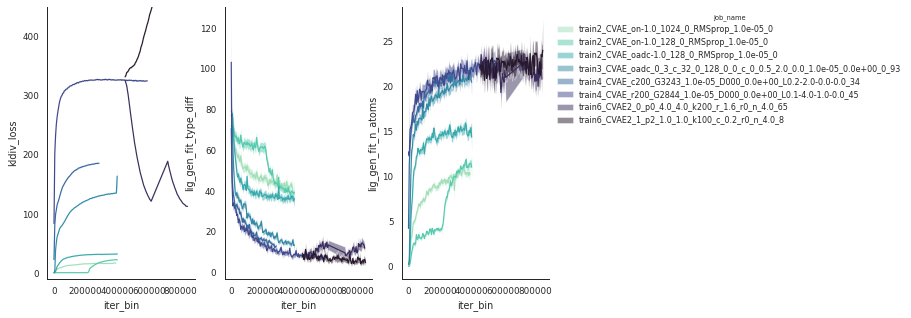

In [632]:
%%time

# plot path of training jobs through hyper param search space
hue = ['job_name'] #['grid_phase', 'job_name']

fig = param_search.plot(
    plot_df[
        ~plot_df['grid_phase'].isin({'poster2', 'prior2', 'prior'})
    ].sort_values(['job_name_idx'] + hue, ascending=True),
    x='iter_bin',
    y=['kldiv_loss', 'lig_gen_fit_type_diff', 'lig_gen_fit_n_atoms'],
    hue=hue, 
    n_cols=4,
    width=3,
    height=5,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(kldiv_loss=[-10, 450], kldiv2_loss=[-10, 450]),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(1.00, 1.00),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)
#fig.suptitle('Training VAEs', y=0.92)
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/training_param_path.{ext}', dpi=400, bbox_extra_inches='tight')

In [626]:
train_param_path

['train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
 'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',
 'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0',
 'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93',
 'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34',
 'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45',
 'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65',
 'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8']

In [703]:
colors = get_palette(3)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803)]

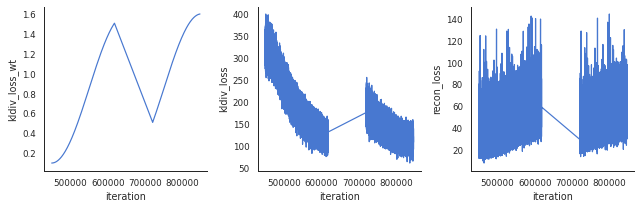

In [715]:
gap_df = train_metrics[
    (train_metrics['job_name'] == 'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65') &
    (train_metrics['data_phase'] == 'train') &
    (train_metrics['grid_phase'] == 'poster') &
    True
]
gap_iter = gap_df.loc[gap_df['iteration'].diff().idxmax()]['iteration']

gap_df[
    (gap_df['iteration'] <= gap_iter)
]
fig = param_search.plot(
    gap_df,
    x='iteration',
    y=['kldiv_loss_wt', 'kldiv_loss', 'recon_loss'],
    plot_func=my_plot, n_cols=3, legend=False
)

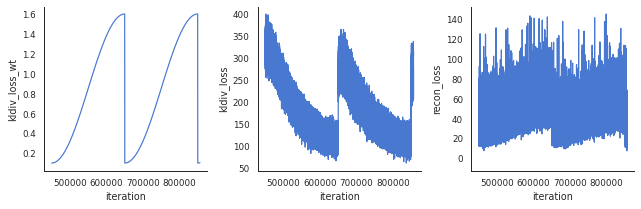

In [721]:
with open('train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65/6988267.stdout') as f:
    lines = f.readlines()
with open('train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65/7017136.stdout') as f:
    lines += f.readlines()

rows = []
for line in lines:
    if line.startswith('[iteration'):
        index_str, value_str = line[1:].split(']')
        row = dict()
        for field in index_str.rstrip().split(' '):
            key, val = field.split('=')
            row[key] = val
        for field in value_str.strip().split(' '):
            key, val = field.split('=')
            row[key] = val
        rows.append(row)
        
stdout_df = pd.DataFrame(rows)
for c in stdout_df:
    try:
        stdout_df[c] = stdout_df[c].astype(float)
    except:
        pass

fig = param_search.plot(
    stdout_df[
    (stdout_df['data_phase'] == 'train') &
    (stdout_df['grid_phase'] == 'poster') &
    True
    ],
    x='iteration',
    y=['kldiv_loss_wt', 'kldiv_loss', 'recon_loss'],
    plot_func=my_plot, n_cols=3, legend=False
)

In [696]:
gap_df

,iteration,data_phase,batch,loss,recon_loss,kldiv_loss,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_n_atoms,lig_radius,lig_gen_fit_type_diff,lig_gen_fit_exact_types,lig_gen_fit_atom_rmsd,forward_data_time,forward_gen_time,forward_fit_time,forward_metrics_time,forward_time,forward_gpu,memory,lig_gen_fit_elem_diff,lig_gen_fit_exact_elems,lig_gen_fit_prop_diff,lig_gen_fit_exact_props,gen_grad_norm,backward_time,backward_grad_time,backward_norm_time,backward_update_time,backward_gpu,random_seed,data_root,train_file,test_file,model_type,typer_fns,use_rec_elems,radius_fn,n_latent,gen_spectral_norm,optim_type,gen_lr,disc_lr,gen_grad_clip,disc_grad_clip,...,disc_conv_per_level,disc_block_type,disc_n_filters,gan_loss_wt,disc_iter,model_phase,grid_phase,steric_loss,forward_disc_time,batch_size,bn_factor,skip_connect,steric_loss_wt,gen_k_iter,gen_n_levels,block_type,growth_rate,width_factor,disc_n_levels,recon_log_var,lig_gen_fit_n_atoms_variance,lig_gen_fit_type_variance,lig_gen_fit_elem_variance,lig_gen_fit_prop_variance,lig_n_atoms_variance,lig_type_variance,lig_elem_variance,lig_prop_variance,kldiv_loss_start_wt,recon_loss_start_wt,steric_loss_start_wt,kldiv2_loss,kldiv2_loss_wt,recon2_loss,recon2_loss_wt,recon2_log_var,prior_grad_norm,gan_loss_start_wt,learn_recon_var,prior_n_layers,kldiv2_loss_start_wt,recon2_loss_start_wt,start_iter,kldiv_loss_end_wt,kldiv_loss_period,kldiv_loss_sched_type,recon_loss_end_wt,recon_loss_period,recon_loss_sched_type,iter_bin
10,450000,train,0,938.880737,24.439087,319.173279,21.533783,385.807129,21.495838,378.837158,24.439087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034019,0.040827,2.384186e-07,0.002778,1.174604,5026.191406,5043.628906,NaN,NaN,NaN,NaN,2717.880581,1.277164,1.246036,0.021826,0.009045,7365.203613,65,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,CVAE2,oadc,True,1.0,128,1,RMSprop,0.00001,0.0,5000,0,...,0.0,NaN,0.0,NaN,0.0,gen,poster,0.057483,0.096682,8.0,0.0,True,1.0,600.0,4.0,r,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,4.0,1.0,100.865105,4.0,101.422295,4.0,0.0,1399.705798,0.0,0.0,0.0,4.0,4.0,450000.0,1.6,200.0,r,4.0,0.0,n,450000
12,450002,train,0,912.093018,25.515331,314.618896,20.474997,363.684998,18.546595,294.946350,25.515331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237623,0.040284,4.768372e-07,0.002771,1.378456,5228.360352,5049.503906,NaN,NaN,NaN,NaN,NaN,0.403500,0.165486,0.231035,0.006784,5396.376953,65,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,CVAE2,oadc,True,1.0,128,1,RMSprop,0.00001,0.0,5000,0,...,0.0,NaN,0.0,NaN,0.0,gen,poster,0.015174,0.097498,8.0,0.0,True,1.0,600.0,4.0,r,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,4.0,1.0,107.880554,4.0,86.758102,4.0,0.0,NaN,0.0,0.0,0.0,4.0,4.0,450000.0,1.6,200.0,r,4.0,0.0,n,450000
14,450004,train,0,1050.492676,43.805046,359.968628,25.710440,538.647705,24.258675,473.619263,43.805046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.089672,0.040770,4.768372e-07,0.002758,1.229933,5228.797852,5056.082031,NaN,NaN,NaN,NaN,NaN,0.404559,0.165023,0.232535,0.006836,5397.561523,65,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,CVAE2,oadc,True,1.0,128,1,RMSprop,0.00001,0.0,5000,0,...,0.0,NaN,0.0,NaN,0.0,gen,poster,0.094430,0.096454,8.0,0.0,True,1.0,600.0,4.0,r,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,4.0,1.0,107.562485,4.0,102.232803,4.0,0.0,NaN,0.0,0.0,0.0,4.0,4.0,450000.0,1.6,200.0,r,4.0,0.0,n,450000
16,450006,train,0,587.791382,20.528698,307.384552,20.194212,343.523102,18.801468,297.556885,20.528698,

In [587]:
%%time

# get average metrics for each job name at each iteration bin
df = train_metrics[
    (train_metrics['data_phase'] == 'test') &
    (train_metrics['iteration'] > 400000)
].groupby(['group_name', 'job_name', 'iter_bin', 'grid_phase']).mean()

# get metrics of best train4 model by iter_bin
best_train4_df = df.loc['4', best_train4_job]

# metrics that we will use to select the best jobs
select_cols = ['lig_gen_fit_n_atoms', 'lig_gen_fit_elem_diff', 'lig_gen_fit_elem_variance']

best_train4_df = best_train4_df[select_cols].unstack().loc[450000]
best_train4_df

CPU times: user 1.08 s, sys: 625 µs, total: 1.08 s
Wall time: 1.08 s


                           grid_phase
lig_gen_fit_n_atoms        poster        22.0560
                           prior          7.9600
lig_gen_fit_elem_diff      poster         2.4440
                           prior             NaN
lig_gen_fit_elem_variance  poster        10.5480
                           prior          4.6424
Name: 450000, dtype: float64

In [614]:
last_train6_df = df.loc['6'].reset_index()

#.groupby(['job_name', 'grid_phase']).last() \
#    .reset_index()
last_train6_df

,job_name,iter_bin,grid_phase,iteration,disc_iter,batch,recon_loss,kldiv_loss,steric_loss,loss,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_n_atoms,lig_radius,lig_gen_fit_type_diff,lig_gen_fit_exact_types,lig_gen_fit_elem_diff,lig_gen_fit_exact_elems,lig_gen_fit_prop_diff,lig_gen_fit_exact_props,lig_gen_fit_atom_rmsd,forward_data_time,forward_gen_time,forward_disc_time,forward_fit_time,forward_metrics_time,memory,forward_time,forward_gpu,gen_grad_norm,backward_grad_time,backward_norm_time,backward_update_time,backward_time,backward_gpu,recon_loss_wt,recon_log_var,kldiv_loss_wt,steric_loss_wt,lig_gen_fit_n_atoms_variance,lig_gen_fit_type_variance,lig_gen_fit_elem_variance,lig_gen_fit_prop_variance,lig_n_atoms_variance,lig_type_variance,lig_elem_variance,lig_prop_variance,batch_size,use_rec_elems,radius_fn,gen_n_filters,gen_conv_per_level,bn_factor,gen_spectral_norm,n_latent,skip_connect,kldiv_loss_start_wt,recon_loss_start_wt,steric_loss_start_wt,gen_lr,gen_grad_clip,disc_grad_clip,n_gen_train_iters,gen_k_iter,random_seed,gen_init_conv_pool,gen_n_levels,growth_rate,width_factor,disc_init_conv_pool,disc_n_levels,disc_conv_per_level,disc_n_filters,n_disc_train_iters,disc_lr,gan_loss_wt,kldiv2_loss,kldiv2_loss_wt,recon2_loss,recon2_loss_wt,recon2_log_var,prior_grad_norm,gan_loss_start_wt,learn_recon_var,prior_n_layers,kldiv2_loss_start_wt,recon2_loss_start_wt,start_iter,kldiv_loss_end_wt,kldiv_loss_period,recon_loss_end_wt,recon_loss_period
0,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,poster,452450.0,0.0,4.0,36.634342,329.042116,0.073996,2.494855e+02,22.691897,437.567612,21.280632,377.903150,36.634342,21.791667,6.203920,23.4250,6.323229,7.558333,0.183333,2.516667,0.316667,5.041667,0.275000,NaN,1.472387,0.045849,0.108547,0.558104,0.003954,14788.215339,2.189941,7197.722578,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.000000,0.100000,1.0,46.965625,28.893750,10.037500,18.856250,71.611458,33.385417,11.666667,21.71875,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.998323,1.0,75.943195,0.5,0.000000,NaN,0.0,0.0,0.0,1.0,0.5,450000.0,0.1,0.0,4.0,0.0
1,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,poster2,452450.0,0.0,4.0,310.711191,327.581041,0.022401,1.344618e+03,22.599290,433.477241,14.448306,118.247033,310.711191,11.000000,3.153866,24.3375,6.159640,58.200000,0.000000,23.012500,0.000000,35.187500,0.000000,NaN,1.330967,0.041994,0.110235,0.327106,0.003770,14789.230625,1.815449,8178.370112,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.000000,0.100000,1.0,7.368750,10.296875,3.631250,6.665625,100.070312,36.443750,11.843750,24.60000,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.324236,1.0,75.336847,0.5,0.000000,NaN,0.0,0.0,0.0,1.0,0.5,450000.0,0.1,0.0,4.0,0.0
2,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,prior,452450.0,0.0,5.0,NaN,NaN,0.038486,3.848642e-02,NaN,NaN,11.840602,116.009681,NaN,8.000000,3.110131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.757957,0.022157,0.084443,0.262372,0.001379,14797.529896,2.130118,8179.563623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.514583,12.858333,4.606250,8.252083,NaN,NaN,NaN,NaN,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.5,450000.0,0.1,0.0,4.0,0.0
3,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,prior2,452450.0,0.0,5.0,NaN,NaN,0.023007,2.300747e-02,NaN,NaN,14.286020,109.710833,NaN,10.387500,3.020450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.634497,0.022303,0.083391,0.314149,0.001382,14797.479258,2.057536,8179.661401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.892188,8.343750,2.587500,5.756250,NaN,NaN,NaN,NaN,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,

In [600]:
# get metrics at last iter_bin of each train6 job
last_train6_df = df.loc['6'].reset_index().groupby(['job_name', 'grid_phase']).last() \
    .reset_index()

last_train6_df = last_train6_df.set_index(['job_name', 'iter_bin', 'grid_phase'])[
    select_cols
].unstack()

last_train6_df['prior_n_atoms'] = np.maximum(
    last_train6_df['lig_gen_fit_n_atoms']['prior'],
    last_train6_df['lig_gen_fit_n_atoms']['prior2'],
)
last_train6_df['prior_stage'] = (
    last_train6_df['lig_gen_fit_n_atoms']['prior2'] > last_train6_df['lig_gen_fit_n_atoms']['prior']
).astype(int) + 1

last_train6_df['poster_elem_diff'] = last_train6_df['lig_gen_fit_elem_diff']['poster']

last_train6_df['prior_increase'] = (
    last_train6_df['prior_n_atoms'] - best_train4_df['lig_gen_fit_n_atoms', 'prior']
)
last_train6_df['recon_decrease'] = (
    last_train6_df['lig_gen_fit_elem_diff', 'poster'] - best_train4_df['lig_gen_fit_elem_diff', 'poster']
)
last_train6_df['total_score'] = last_train6_df['prior_increase'] - last_train6_df['recon_decrease']

last_train6_df.reset_index().set_index(['job_name', 'prior_stage'])[
    ['iter_bin', 'total_score', 'prior_increase', 'recon_decrease', 'prior_n_atoms', 'poster_elem_diff']
].sort_values('total_score', ascending=False)

,,iter_bin,total_score,prior_increase,recon_decrease,prior_n_atoms,poster_elem_diff
,grid_phase,,,,,,
job_name,prior_stage,,,,,,
train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,2,495000,3.942333,4.415000,0.472667,12.375000,2.916667
train6_CVAE2_0_p0_2.0_1.0_k300_r_0.8_r0_n_4.0_19,1,700000,3.800667,4.490000,0.689333,12.450000,3.133333
train6_CVAE2_1_p1_0.5_2.0_k0_n_0.1_r250_d_3.0_47,2,485000,3.452750,3.508750,0.056000,11.468750,2.500000
train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65,1,730000,3.414556,3.762222,0.347667,11.722222,2.791667
train6_CVAE2_0_p1_1.0_2.0_k150_d_0.2_r0_n_4.0_95,2,490000,3.364208,3.274375,-0.089833,11.234375,2.354167
train6_CVAE2_1_p1_1.0_4.0_k0_n_0.1_r0_n_4.0_19,2,710000,3.359000,1.790000,-1.569000,9.750000,0.875000
train6_CVAE2_0_p0_2.0_1.0_k150_c_2.4_r0_n_4.0_59,1,730000,3.350667,6.815000,3.464333,14.775000,5.908333
train6_CVAE2_0_p0_4.0_2.0_k500_d_4.0_r0_n_4.0_78,1,675000,3.317333,5.220556,1.903222,13.180556,4.347222


In [585]:




for metric in select_cols:
    for grid_phase in last_train6_df[c]:
        last_train6_df[(metric,grid_phase)] -= best_train4_df[(metric,grid_phase)]
        
last_train6_df['prior_stage'] -= best_train4_df[('lig_gen_fit_n_atoms','prior')]

best_train6_jobs = last_train6_df[
    (last_train6_df['prior_n_atoms'] > 0) & 
    True
].sort_values(('prior_n_atoms'), ascending=False)
best_train6_jobs

KeyError: ('lig_gen_fit_n_atoms', 'poster2')

In [536]:
bad_train6_jobs = last_train6_df.reset_index().set_index(['job_name', 'iter_bin', 'model_stage']).unstack()
bad_train6_jobs = bad_train6_jobs[
    (
        (bad_train6_jobs['lig_gen_fit_n_atoms']['prior'][1] < 0) &
        (bad_train6_jobs['lig_gen_fit_n_atoms']['prior'][2] < 0)
    ) |
    (bad_train6_jobs['lig_gen_fit_elem_diff']['poster'][1] > 15)
]
bad_train6_jobs

lig_gen_fit_n_atoms  \
grid_phase                                                             poster   
model_stage                                                                 1   
job_name                                         iter_bin                       
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000              3.360000   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000             -0.390000   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000              1.040556   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000              1.297500   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000              0.043333   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000              1.047500   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000              1.255833   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000             -0.490000   
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26 585000             -0.570556   

                                                                      \
grid_phase                                                             
model_stage                                                        2   
job_name                                         iter_bin              
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000   -13.015000   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000    -6.577500   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000    -4.556667   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000    -3.671250   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000   -13.527500   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000   -11.671250   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000   -10.546250   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000   -13.327500   
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26 585000    -7.452500   

                                                                               \
grid_phase                                                    prior             
model_stage                                                       1         2   
job_name                                         iter_bin                       
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000   -1.951667 -0.160000   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000   -7.618333 -3.597500   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000   -8.715556 -1.910000   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000   -8.785000 -6.097500   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000   -7.643333 -1.460000   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000   -8.264167 -0.253750   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000   -7.305833 -0.816250   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000   -3.868333 -0.660000   
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26 585000   -8.590556 -0.680833   

                                                          lig_gen_fit_elem_diff  \
grid_phase                                                               poster   
model_stage                                                                   1   
job_name                                         iter_bin                         
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000               -0.216667   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000               -0.716667   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000               -0.480556   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000               -0.112500   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000               -0.216667   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000               -0.112500   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000                0.116667   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000               -0.283333   
train6_CVAE2_1_p0

In [542]:
# cancel running train6 jobs that are not promising
cancel_job_ids = train_jobs[
    (train_jobs['job_state'] == 'R') &
    train_jobs['job_name'].isin(bad_train6_jobs.reset_index()['job_name'])
]['job_id'].unique()

param_search.cancel(cancel_job_ids)
len(cancel_job_ids), cancel_job_ids

(9,
 array([6988239, 6988245, 6988287, 6988289, 6988290, 6988300, 6988302,
        6988311, 6988315], dtype=object))

In [30]:
# which of the best train6 jobs are NOT currently running and why?
train_jobs[
    train_jobs['job_name'].isin(best_train6_jobs['job_name']) &
    ~train_jobs['job_name'].isin(running_jobs['job_name']) &
    True
].sort_values(['group_name', 'job_name', 'job_id']).set_index(['group_name', 'job_name', 'job_id'])[
    ['iteration', 'test_recon_loss', 'job_state', 'stderr']
]

iteration  \
group_name job_name                                                            job_id               
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090   206618.0   
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091   205722.0   
                                                                               6971529        NaN   
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165   371125.0   

                                                                                        test_recon_loss  \
group_name job_name                                                            job_id                     
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090              NaN   
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091              NaN   
                                                                               6971529              NaN   
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165              NaN   

                                                                                       job_state  \
group_name job_name                                                            job_id              
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090       ERR   
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091       ERR   
                                                                               6971529        PD   
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165       ERR   

                                                                                                                                                                 stderr  
group_name job_name                                                            job_id                                                                                    
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090  slurmstepd: error: *** JOB 6922090 ON g015 CANCELLED AT 2021-07-05T23:19:02 ***  
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091  slurmstepd: error: *** JOB 6922091 ON g017 CANCELLED AT 2021-07-05T23:19:02 ***  
                                                                               6971529                                                                             None  
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165  slurmstepd: error: *** JOB 6922165 ON g011 CANCELLED AT 2021-07-05T23:19:02 ***

In [51]:
colors = get_palette(
    n_hues=16,
    n_shades=2,
    mode='husl',
    min_val=0.1,
    max_val=0.9
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.7618514458180183, 0.3609708339002302, 0.43229625732599575),
 (0.9637843654351403, 0.5628421681618326, 0.6346364032287142),
 (0.7592324596036727, 0.38151681310192115, 0.1802169309481654),
 (0.964587691330481, 0.5824618505428452, 0.37715770369882257),
 (0.6381917822622428, 0.45361296434794035, 0.17904750580255635),
 (0.8434745951153879, 0.6554969770437833, 0.374923376667084),
 (0.556825540946517, 0.48704140663235673, 0.17840662320169995),
 (0.7618429025922271, 0.6895256742974988, 0.3711068494528871),
 (0.4750695180000701, 0.5124384666476989, 0.17787585747731377),
 (0.6763278291662416, 0.7171094332674639, 0.359446164329041),
 (0.34820961607050754, 0.5395890587408472, 0.17726522887303223),
 (0.5447435201582534, 0.7445522496214831, 0.36777270200117573),
 (0.18121378837827168, 0.5527949335887479, 0.3310984894514143),
 (0.3735881292586676, 0.757812617054055, 0.5280902666471671),
 (0.18686112847529815, 0.5449136796928328, 0.4482527230943586),
 (0.3784753070652855, 0.7498970432594655, 0.6490918944883306),
 (0.19089357060095424, 0.5389909169908954, 0.5135410808331553),
 (0.3818317640967367, 0.7439243031163321, 0.7172193808207535),
 (0.19495667512302495, 0.5327593061007933, 0.5710795116366396),
 (0.38882834892933305, 0.7367186591938516, 0.7762749050281283),
 (0.20075167650472064, 0.5233838754230236, 0.6438718625927217),
 (0.396613373745806, 0.7266914697042068, 0.8496996700717578),
 (0.29685152664743564, 0.49611383261605313, 0.7508046435423512),
 (0.49591813218923886, 0.6987948215380508, 0.9567819903277834),
 (0.5131113722495746, 0.44270184416593383, 0.7555273367248874),
 (0.7156521542711255, 0.6452727096521343, 0.9565123723657867),
 (0.6618866714069486, 0.3706939187642878, 0.75152812336417),
 (0.866040410141313, 0.5716638979261983, 0.956207027851774),
 (0.7527390687003886, 0.31763221337856823, 0.6830566572816761),
 (0.958148206336938, 0.5174013127029479, 0.8878375055467185),
 (0.7573960764092733, 0.3427985440795964, 0.5631437824457652),
 (0.9612894608678452, 0.5436634925774739, 0.7662638266444659)]

CPU times: user 2min 21s, sys: 47.9 s, total: 3min 9s
Wall time: 4min 14s


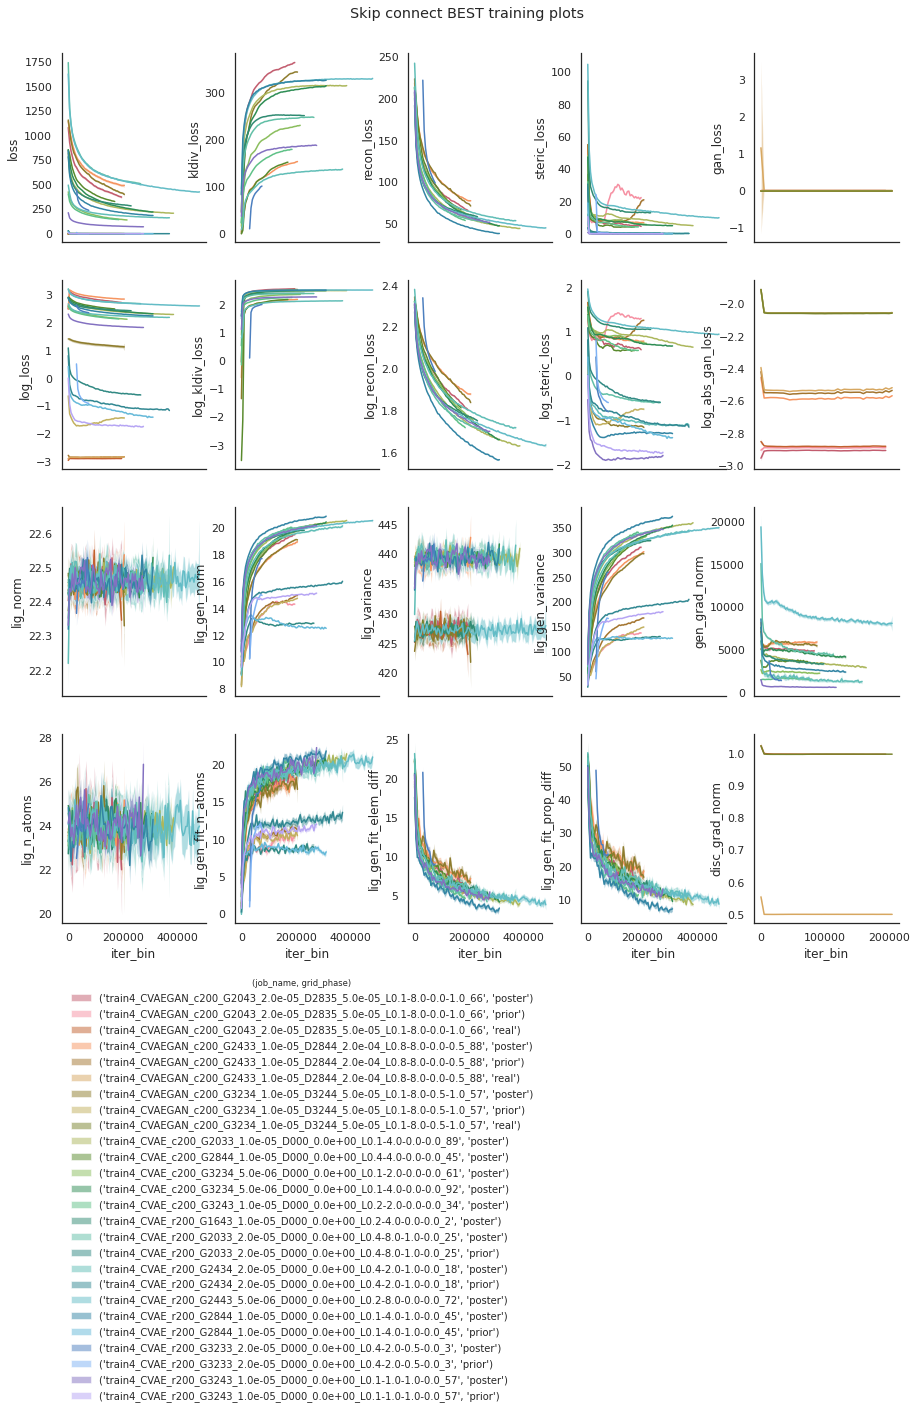

In [52]:
%%time
hue = ['job_name', 'grid_phase']

# plot best train4 job, looking at posterior vs prior
fig = param_search.plot(
    plot_df[
        (plot_df['job_name'].isin(best_train4_jobs['job_name'])) &
        ~(plot_df['recon_loss'] > 300) &
        ~(plot_df['steric_loss'] > 300) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Skip connect BEST training plots', y=0.92)
fig.savefig('plots/train4_best_training_plots.png')

# 5. Test evaluations

Perform inference using trained generative models, using different sampling methods to generate novel molecules.

[Table of contents](#Table-of-contents)

In [4]:
gen_expt_dir = os.path.join(add_expt_dir, 'generate')
os.chdir(gen_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate'

In [5]:
np.random.seed(0)
all_test_pockets = pd.read_csv('../../data/TEST_POCKETS', sep=' ', names=['pocket_name', 'rec_name', 'n_ligands', 'ligands'])
print(all_test_pockets['n_ligands'].describe())

test_targets = all_test_pockets[
    (all_test_pockets['n_ligands'] > 5)
].groupby('pocket_name').sample(1).sample(10)

test_targets.to_csv('SELECTED_TEST_TARGETS', sep=' ', header=False, index=False)
print(test_targets['n_ligands'].sum())
print(len(set(sum((x.split(',') for x in test_targets['ligands']), []))))
test_targets

count    9115.000000
mean       11.576083
std        12.961100
min         1.000000
25%         3.000000
50%         6.000000
75%        16.000000
max        79.000000
Name: n_ligands, dtype: float64
90
89


,pocket_name,rec_name,n_ligands,ligands
935,B4GT1_HUMAN_125_398_0,2ah9_B_rec,6,"bgn,udp,udh,cto,ud2,upg"
4471,KAT2B_HUMAN_715_831_0,5lvq_A_rec,14,"aly,5wv,5wz,2lx,5ws,5wu,2qc,..."
6137,PA2GA_HUMAN_21_144_0,5g3n_A_rec,8,"x28,oap,8in,6in,u8d,bhp,i3n,gel"
3613,G6PI_MOUSE_1_557_0,1u0f_A_rec,6,"g6p,6pg,s6p,der,f6p,a5p"
3279,FABG_PSEAE_1_247_0,4bnw_C_rec,13,"36k,nkh,36i,j2t,fxe,q7u,3x3,..."
2222,CP2B6_HUMAN_20_491_catalytic_0,4i91_A_rec,7,"cpz,85d,cae,sne,tmh,3v4,82s"
7373,PYGL_HUMAN_5_844_0,2ati_A_rec,7,"avf,ave,ihu,055,25d,mrd,avd"
4562,KHK_HUMAN_3_298_0,2hw1_A_rec,11,"tr4,lj9,a4j,tr2,anp,a4g,a3y,..."
4345,INHA_MYCTU_1_269_0,1bvr_C_rec,11,"xt5,tcu,3kx,3ky,2tk,i4i,uud,..."
803,AROK_MYCTU_1_176_0,1zyu_A_rec,7,"adp,skm,anp,acp,s3p,dhk,k2q"


In [687]:
import param_search
from param_search import params

# define parameter space

base_params = param_search.ParamSpace(
    group_name='0',
    random_seed=0,
    sbatch_line='#SBATCH -C M12|2080Ti',
)

model_params = (
    params.ParamSpace(
        model_type='CVAE',
        prior_n_layers=0,
        train_job_name='train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65',
        train_iter=600000,
    ) + \
    params.ParamSpace(
        model_type='CVAE2',
        prior_n_layers=2,
        train_job_name='train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8',
        train_iter=730000,
    )
)

sample_params = (
    params.ParamSpace( # posterior
        prior=0,
        var_factor=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
        post_factor=1.0,
        truncate=False,
    ) + \
    params.ParamSpace( # prior
        prior=1,
        var_factor=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
        post_factor=0.0,
        truncate=False,
    ) + \
    params.ParamSpace( # post/prior interp (will this work for CVAE2?)
        prior=0,
        var_factor=1.0,
        post_factor=[1.2, 0.8, 0.6, 0.4, 0.2, -0.2],
        truncate=False,
    )
)

d = []
for i, target in test_targets.iterrows():
    
    d.append(params.ParamSpace(
        pocket_name=target['pocket_name'],
        rec_name=target['rec_name'],
        n_examples=target['n_ligands'],
        n_samples=100,
    ))
    
assert len(d) == 10
data_params = d[0] + d[1] + d[2] + d[3] + d[4] + d[5] + d[6] + d[7] + d[8] + d[9]

gen_params = list(base_params * model_params * sample_params * data_params)

for p in gen_params:
    p['stage2'] = (p['model_type'] == 'CVAE2' and p['prior'])

name_format = 'gen{group_name}_{model_type}_{rec_name}_{prior}_{var_factor}_{post_factor}'

len(gen_params)

360

In [269]:
# estimate evaluation time
n_examples = test_targets['n_ligands'].mean()
n_samples = d[0]['n_samples'][0]
s_per_sample = 10

n_examples * n_samples * s_per_sample / 3600 # hours per job

2.5

In [688]:
# set job submission order
for p in gen_params:
    name = name_format.format(**p)
    print(name)

gen0_CVAE_2ah9_B_rec_0_0.25_1.0
gen0_CVAE_5lvq_A_rec_0_0.25_1.0
gen0_CVAE_5g3n_A_rec_0_0.25_1.0
gen0_CVAE_1u0f_A_rec_0_0.25_1.0
gen0_CVAE_4bnw_C_rec_0_0.25_1.0
gen0_CVAE_4i91_A_rec_0_0.25_1.0
gen0_CVAE_2ati_A_rec_0_0.25_1.0
gen0_CVAE_2hw1_A_rec_0_0.25_1.0
gen0_CVAE_1bvr_C_rec_0_0.25_1.0
gen0_CVAE_1zyu_A_rec_0_0.25_1.0
gen0_CVAE_2ah9_B_rec_0_0.5_1.0
gen0_CVAE_5lvq_A_rec_0_0.5_1.0
gen0_CVAE_5g3n_A_rec_0_0.5_1.0
gen0_CVAE_1u0f_A_rec_0_0.5_1.0
gen0_CVAE_4bnw_C_rec_0_0.5_1.0
gen0_CVAE_4i91_A_rec_0_0.5_1.0
gen0_CVAE_2ati_A_rec_0_0.5_1.0
gen0_CVAE_2hw1_A_rec_0_0.5_1.0
gen0_CVAE_1bvr_C_rec_0_0.5_1.0
gen0_CVAE_1zyu_A_rec_0_0.5_1.0
gen0_CVAE_2ah9_B_rec_0_1.0_1.0
gen0_CVAE_5lvq_A_rec_0_1.0_1.0
gen0_CVAE_5g3n_A_rec_0_1.0_1.0
gen0_CVAE_1u0f_A_rec_0_1.0_1.0
gen0_CVAE_4bnw_C_rec_0_1.0_1.0
gen0_CVAE_4i91_A_rec_0_1.0_1.0
gen0_CVAE_2ati_A_rec_0_1.0_1.0
gen0_CVAE_2hw1_A_rec_0_1.0_1.0
gen0_CVAE_1bvr_C_rec_0_1.0_1.0
gen0_CVAE_1zyu_A_rec_0_1.0_1.0
gen0_CVAE_2ah9_B_rec_0_2.0_1.0
gen0_CVAE_5lvq_A_rec_0_2.0_1.

In [690]:
gen_job_files = []
for template_file in [
    'generate.config', 'generate.sh'
]:
    gen_job_files = param_search.setup(
        expt_dir=gen_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=[p for p in gen_params if p['post_factor'] in {1.4, -0.4}],
    )

gen_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_2ah9_B_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_5lvq_A_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_5g3n_A_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_1u0f_A_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_4bnw_C_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_4i91_A_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_2ati_A_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_2hw1_A_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_1bvr_C_rec_0_0.25_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/gener

In [691]:
job_ids = param_search.submit(gen_job_files)
print(job_ids)

[7024330, 7024331, 7024332, 7024333, 7024334, 7024335, 7024336, 7024337, 7024338, 7024339, 7024340, 7024341, 7024342, 7024343, 7024344, 7024345, 7024346, 7024347, 7024348, 7024349, 7024350, 7024351, 7024352, 7024353, 7024354, 7024355, 7024356, 7024357, 7024358, 7024359, 7024360, 7024361, 7024362, 7024363, 7024364, 7024365, 7024366, 7024367, 7024368, 7024369, 7024370, 7024371, 7024372, 7024373, 7024374, 7024375, 7024376, 7024377, 7024378, 7024379, 7024380, 7024381, 7024382, 7024383, 7024384, 7024385, 7024386, 7024387, 7024388, 7024389, 7024390, 7024391, 7024392, 7024393, 7024394, 7024395, 7024396, 7024397, 7024398, 7024399, 7024400, 7024401, 7024402, 7024403, 7024404, 7024405, 7024406, 7024407, 7024408, 7024409, 7024410, 7024411, 7024412, 7024413, 7024414, 7024415, 7024416, 7024417, 7024418, 7024419, 7024420, 7024421, 7024422, 7024423, 7024424, 7024425, 7024426, 7024427, 7024428, 7024429, 7024430, 7024431, 7024432, 7024433, 7024434, 7024435, 7024436, 7024437, 7024438, 7024439, 7024440, 

In [6]:
gen_jobs = pd.DataFrame(dict(
    job_id=[
        # first working gen0 submit
        [7023120, 7023121, 7023122, 7023123, 7023124, 7023125, 7023126, 7023127, 7023128, 7023129, 7023130, 7023131, 7023132, 7023133, 7023134, 7023135, 7023136, 7023137, 7023138, 7023139, 7023140, 7023141, 7023142, 7023143, 7023144, 7023145, 7023146, 7023147, 7023148, 7023149, 7023150, 7023151, 7023152, 7023153, 7023154, 7023155, 7023156, 7023157, 7023158, 7023159, 7023160, 7023161, 7023162, 7023163, 7023164, 7023165, 7023166, 7023167, 7023168, 7023169, 7023170, 7023171, 7023172, 7023173, 7023174, 7023175, 7023176, 7023177, 7023178, 7023179, 7023180, 7023181, 7023182, 7023183, 7023184, 7023185, 7023186, 7023187, 7023188, 7023189, 7023190, 7023191, 7023192, 7023193, 7023194, 7023195, 7023196, 7023197, 7023198, 7023199, 7023200, 7023201, 7023202, 7023203, 7023204, 7023205, 7023206, 7023207, 7023208, 7023209, 7023210, 7023211, 7023212, 7023213, 7023214, 7023215, 7023216, 7023217, 7023218, 7023219, 7023220, 7023221, 7023222, 7023223, 7023224, 7023225, 7023226, 7023227, 7023228, 7023229, 7023230, 7023231, 7023232, 7023233, 7023234, 7023235, 7023236, 7023237, 7023238, 7023239, 7023240, 7023241, 7023242, 7023243, 7023244, 7023245, 7023246, 7023247, 7023248, 7023249, 7023250, 7023251, 7023252, 7023253, 7023254, 7023255, 7023256, 7023257, 7023258, 7023259, 7023260, 7023261, 7023262, 7023263, 7023264, 7023265, 7023266, 7023267, 7023268, 7023269, 7023270, 7023271, 7023272, 7023273, 7023274, 7023275, 7023276, 7023277, 7023278, 7023279, 7023280, 7023281, 7023282, 7023283, 7023284, 7023285, 7023286, 7023287, 7023288, 7023289, 7023290, 7023291, 7023292, 7023293, 7023294, 7023295, 7023296, 7023297, 7023298, 7023299, 7023300, 7023301, 7023302, 7023303, 7023304, 7023305, 7023306, 7023307, 7023308, 7023309, 7023310, 7023311, 7023312, 7023313, 7023314, 7023315, 7023316, 7023317, 7023318, 7023319, 7023320, 7023321, 7023322, 7023323, 7023324, 7023325, 7023326, 7023327, 7023328, 7023329, 7023330, 7023331, 7023332, 7023333, 7023334, 7023335, 7023336, 7023337, 7023338, 7023339, 7023340, 7023341, 7023342, 7023343, 7023344, 7023345, 7023346, 7023347, 7023348, 7023349, 7023350, 7023351, 7023352, 7023353, 7023354, 7023355, 7023356, 7023357, 7023358, 7023359],
        # resubmit gen0 error jobs
        [7023396, 7023397, 7023398, 7023399, 7023400, 7023401, 7023402, 7023403, 7023404, 7023405, 7023406, 7023407, 7023408, 7023409, 7023410, 7023411, 7023412, 7023413, 7023414, 7023415, 7023416, 7023417, 7023418, 7023419, 7023420, 7023421, 7023422, 7023423, 7023424, 7023425, 7023426, 7023427, 7023428, 7023429, 7023430, 7023431, 7023432, 7023433, 7023434, 7023435, 7023436, 7023437, 7023438, 7023439, 7023440, 7023441, 7023442, 7023443, 7023444, 7023445, 7023446, 7023447, 7023448, 7023449, 7023450, 7023451, 7023452, 7023453, 7023454, 7023455, 7023456, 7023457, 7023458, 7023459, 7023460, 7023461, 7023462, 7023463, 7023464, 7023465, 7023466, 7023467, 7023468, 7023469, 7023470, 7023471, 7023472, 7023473, 7023474, 7023475, 7023476, 7023477, 7023478, 7023479, 7023480, 7023481, 7023482, 7023483, 7023484, 7023485, 7023486, 7023487, 7023488, 7023489, 7023490, 7023491, 7023492, 7023493, 7023494, 7023495, 7023496, 7023497],
        # resubmit more error jobs (cancelled redundant)
        [7023506, 7023507, 7023508, 7023509, 7023510, 7023511, 7023512, 7023513, 7023514, 7023515, 7023516, 7023517, 7023518, 7023519, 7023520, 7023521, 7023522, 7023523, 7023524, 7023525, 7023526, 7023527, 7023528, 7023529, 7023530, 7023531, 7023532, 7023533, 7023534, 7023535, 7023536, 7023537, 7023538, 7023539, 7023540, 7023541, 7023542, 7023543, 7023544, 7023545, 7023546, 7023547, 7023548, 7023549, 7023550, 7023551, 7023552, 7023553, 7023554, 7023555, 7023556, 7023557, 7023558, 7023559, 7023560, 7023561, 7023562, 7023563, 7023564, 7023565, 7023566, 7023567, 7023568, 7023569, 7023570, 7023571, 7023572, 7023573, 7023574, 7023575, 7023576, 7023577, 7023578, 7023579, 7023580, 7023581, 7023582, 7023583, 7023584, 7023585, 7023586, 7023587, 7023588, 7023589, 7023590, 7023591, 7023592, 7023593, 7023594, 7023595, 7023596, 7023597, 7023598, 7023599, 7023600, 7023601, 7023602, 7023603, 7023604, 7023605, 7023606, 7023607],
        # fix post_factor bug and resubmit affected jobs
        [7023617, 7023618, 7023619, 7023620, 7023621, 7023622, 7023623, 7023624, 7023625, 7023626, 7023627, 7023628, 7023629, 7023630, 7023631, 7023632, 7023633, 7023634, 7023635, 7023636, 7023637, 7023638, 7023639, 7023640, 7023641, 7023642, 7023643, 7023644, 7023645, 7023646, 7023647, 7023648, 7023649, 7023650, 7023651, 7023652, 7023653, 7023654, 7023655, 7023656, 7023657, 7023658, 7023659, 7023660, 7023661, 7023662, 7023663, 7023664, 7023665, 7023666, 7023667, 7023668, 7023669, 7023670, 7023671, 7023672, 7023673, 7023674, 7023675, 7023676, 7023677, 7023678, 7023679, 7023680, 7023681, 7023682, 7023683, 7023684, 7023685, 7023686, 7023687, 7023688, 7023689, 7023690, 7023691, 7023692, 7023693, 7023694, 7023695, 7023696],
        # resubmit remaining minimizedAffinity key error jobs (were launched before the fix)
        [7023776, 7023777, 7023778, 7023779, 7023780, 7023781, 7023782, 7023783, 7023784, 7023785, 7023786, 7023787, 7023788, 7023789, 7023790, 7023791, 7023792, 7023793, 7023794],
        # extend param ranges of var_factor and post_factor
        [7024330, 7024331, 7024332, 7024333, 7024334, 7024335, 7024336, 7024337, 7024338, 7024339, 7024340, 7024341, 7024342, 7024343, 7024344, 7024345, 7024346, 7024347, 7024348, 7024349, 7024350, 7024351, 7024352, 7024353, 7024354, 7024355, 7024356, 7024357, 7024358, 7024359, 7024360, 7024361, 7024362, 7024363, 7024364, 7024365, 7024366, 7024367, 7024368, 7024369, 7024370, 7024371, 7024372, 7024373, 7024374, 7024375, 7024376, 7024377, 7024378, 7024379, 7024380, 7024381, 7024382, 7024383, 7024384, 7024385, 7024386, 7024387, 7024388, 7024389, 7024390, 7024391, 7024392, 7024393, 7024394, 7024395, 7024396, 7024397, 7024398, 7024399, 7024400, 7024401, 7024402, 7024403, 7024404, 7024405, 7024406, 7024407, 7024408, 7024409, 7024410, 7024411, 7024412, 7024413, 7024414, 7024415, 7024416, 7024417, 7024418, 7024419, 7024420, 7024421, 7024422, 7024423, 7024424, 7024425, 7024426, 7024427, 7024428, 7024429, 7024430, 7024431, 7024432, 7024433, 7024434, 7024435, 7024436, 7024437, 7024438, 7024439, 7024440, 7024441, 7024442, 7024443, 7024444, 7024445, 7024446, 7024447, 7024448, 7024449],
    ],
    group_name=[0,0,0,0,0,0]
)).explode('job_id')

In [7]:
%%time
import param_search

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

print('Getting queue status')
qstat = param_search.status(job=gen_jobs.job_id)

print('Merging data frames')
gen_jobs = gen_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
gen_jobs['work_dir'] = gen_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
gen_jobs['job_name'] = gen_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
gen_jobs['job_file'] = gen_jobs.apply(lambda x: '{work_dir}/generate.sh'.format(**x), axis=1)
gen_jobs['stdout_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
gen_jobs['stderr_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
gen_jobs['metrics_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_name}.gen_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 224 ms, sys: 62.5 ms, total: 287 ms
Wall time: 482 ms


In [8]:
%%time

print('Reading stdout files')
gen_jobs['stdout'] = gen_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    output_pat=r'^(\[example_idx=\d+ .+\].*)'
)
print()

print('Reading stderr files')
gen_jobs['stderr'] = gen_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
gen_jobs['job_state'] = gen_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(gen_jobs['job_name'].unique())}
gen_jobs['job_name_idx'] = gen_jobs['job_name'].map(job_name_idx)

Reading stdout files
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Reading stderr files
......................................................................................................................................................................................................................................................................................................

In [9]:
pd.set_option('display.max_rows', 524)
rec_n_ligands = test_targets.set_index('rec_name')['n_ligands']
has = lambda x: not pd.isnull(x)

gen_jobs['rec_name'] = gen_jobs['job_name'].map(
    lambda x: x.split('rec')[0].split('_', 2)[2] + 'rec' if has(x) else x
)
gen_jobs['n_ligands'] = gen_jobs['rec_name'].map(
    lambda x: rec_n_ligands[x] if has(x) else x
)

gen_jobs['example_idx'] = gen_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=(\d+) ', x).group(1)) if has(x) else x
)
gen_jobs['sample_idx'] = gen_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=\d+ sample_idx=(\d+) ', x).group(1)) if has(x) else np.nan
)
gen_jobs['pct_done'] = (gen_jobs['example_idx']*100 + gen_jobs['sample_idx'])/(gen_jobs['n_ligands']*100-1)

gen_jobs['t_left'] = gen_jobs['runtime'].map(as_timedelta) / gen_jobs['pct_done'] * (1-gen_jobs['pct_done'])
gen_jobs['t_left'] = gen_jobs['t_left'].map(lambda x: x.total_seconds() / 3600 if has(x) else x)

running_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'R')
running_jobs = running_jobs[running_jobs] # drop non-running jobs

gen_jobs[
    (gen_jobs['group_name'] == 0) &
    gen_jobs['job_name'].isin(running_jobs.index) &
    True
].set_index(['group_name', 'job_name', 'job_id']).sort_values(['job_name_idx','job_id'])[
    ['queue', 'job_state', 'runtime', 'n_ligands', 'pct_done', 't_left', 'stdout', 'stderr']
]

,,,queue,job_state,runtime,n_ligands,pct_done,t_left,stdout,stderr
group_name,job_name,job_id,,,,,,,,


In [10]:
# resubmit jobs with intermediate post_factor != 0.0 or 1.0
#   since it was not getting pass in correctly, defaulted to 1.0
resub_jobs = gen_jobs[
    gen_jobs['job_name'].map(lambda x: float(x.rsplit('_', 1)[1]) not in {0.0, 1.0} if x else False)
]

resub_jobs #job_ids = param_search.submit(resub_jobs['job_file'].unique()); repr(job_ids)
repr(job_ids)

NameError: name 'job_ids' is not defined

In [ ]:
# resubmit jobs whose latest submission errored out
error_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'ERR')
error_jobs = error_jobs[error_jobs ] # drop non-error jobs

error_jobs = gen_jobs[
    gen_jobs['job_name'].isin(error_jobs.index)
]
error_jobs #job_ids = param_search.submit(error_jobs['job_file'].unique()); repr(job_ids)

In [11]:
%%time

# read in test generative metrics for completed jobs
done_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'OK')
done_jobs = done_jobs[done_jobs ] # drop incomplete jobs

done_jobs = gen_jobs[
    gen_jobs['job_name'].isin(done_jobs.index)
]

gen_metrics = param_search.metrics(done_jobs.reset_index()['job_file'].unique())

CPU times: user 14.2 s, sys: 1.29 s, total: 15.5 s
Wall time: 16.6 s


In [12]:
gen_param_cols = ['model_type', 'rec_name', 'n_examples', 'post_factor', 'var_factor']
gen_metrics.groupby(gen_param_cols)[['sample_idx']].count()

sample_idx
model_type rec_name   n_examples post_factor var_factor            
CVAE       1bvr_C_rec 11         -0.2        1.00              1100
                                  0.0        0.25              1100
                                             0.50              1100
                                             1.00              1100
                                             2.00              1100
                                             4.00              1100
                                             8.00              1100
                                  0.2        1.00              1100
                                  0.4        1.00              1100
                                  0.6        1.00              1100
                                  0.8        1.00              1100
                                  1.0        0.25              1100
                                             0.50              1100
                                             1.00              1100
                                             2.00              1100
                                             4.00              1100
                                             8.00              1100
                                  1.2        1.00              1100
           1u0f_A_rec 6          -0.2        1.00               600
                                  0.0        0.25               600
                                             0.50               600
                                             1.00               600
                                             2.00               600
                                             4.00               600
                                             8.00               600
                                  0.2        1.00               600
                                  0.4        1.00               600
                                  0.6        1.00               600
                                  0.8        1.00               600
                                  1.0        0.25               600
                                             0.50               600
                                             1.00               600
                                             2.00               600
                                             4.00               600
                                             8.00               600
                                  1.2        1.00               600
           1zyu_A_rec 7          -0.2        1.00               700
                                  0.0        0.25               700
                                             0.50               700
                                             1.00               700
                                             2.00               700
                                             4.00               700
                                             8.00               700
                                  0.2        1.00               700
                                  0.4        1.00               700
                                  0.6        1.00               700
                                  0.8        1.00               700
                                  1.0        0.25               700
                                             0.50               700
                                             1.00               700
                                             2.00               700
                                             4.00               700
                                             8.00               700
                                  1.2        1.00               700
           2ah9_B_rec 6          -0.2        1.00               600
                                  0.0        0.25               600
                                             0.50               600
                                             

In [196]:
import matplotlib as mpl
has = lambda x: not pd.isnull(x)

def my_gen_plot(y, *args, **kwargs):
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    if y in pct_cols:
        ax = sns.barplot(y=y, *args, **kwargs)
        plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    else:
        ax = sns.boxplot(y=y, *args, **kwargs)
    return ax

mol_val_col = 'Valid'
mol_nov_col = 'Novel'
mol_unq_col = 'Unique'
higher_cnn_aff_col = '$\Delta$CNN affinity > 0'
lower_vina_aff_col = '$\Delta$Vina energy < 0'

mol_wt_col = 'Molecular weight'
mol_sim_col = 'Sim. to real ligand'
vina_aff_col = '$\Delta$Vina energy'
cnn_aff_col = '$\Delta$CNN affinity'
fcd_col = 'Fréchet ChemNet distance'

model_col = 'Model'
target_col = 'PDB ID'
var_factor_col = 'Variation factor'
post_factor_col = 'Posterior factor'
post_prior_col = 'Posterior/prior'

plot_df = gen_metrics.copy()
plot_df[mol_val_col] = plot_df['lig_gen_fit_add_valid']*100
plot_df[mol_wt_col] = plot_df['lig_gen_fit_add_MW']
plot_df[mol_sim_col] = plot_df['lig_gen_fit_add_ob_sim']
plot_df[vina_aff_col] = plot_df['lig_gen_fit_add_vina_aff_diff']
plot_df[cnn_aff_col] = plot_df['lig_gen_fit_add_cnn_aff_diff']
plot_df[higher_cnn_aff_col] = (plot_df['lig_gen_fit_add_cnn_aff_diff'] > 0)*100
plot_df[lower_vina_aff_col] = (plot_df['lig_gen_fit_add_vina_aff_diff'] < 0)*100

plot_df[model_col] = plot_df['model_type'].map({'CVAE':'CVAE1', 'CVAE2':'CVAE2'}.__getitem__)
plot_df[target_col] = plot_df['rec_name'].map(lambda x: x.split('_', 1)[0])
plot_df[var_factor_col] = plot_df['var_factor']
plot_df[post_factor_col] = plot_df['post_factor']
plot_df[post_prior_col] = plot_df['prior'].map(['Posterior', 'Prior'].__getitem__)

# replace invalid smiles with nan
plot_df['lig_gen_fit_add_SMILES'] = \
    plot_df['lig_gen_fit_add_SMILES'].where(plot_df['lig_gen_fit_add_valid'])

# remove Hs from smiles
plot_df['lig_gen_fit_add_SMILES_noh'] = plot_df['lig_gen_fit_add_SMILES'].map(
    lambda x: liGAN.molecules.Molecule.from_smi(x, sanitize=False).remove_hs().to_smi() if has(x) else x
)

gen_y = [
    mol_wt_col,
    mol_sim_col,
    fcd_col,
    vina_aff_col,
    cnn_aff_col,
]

pct_cols = {mol_val_col, mol_nov_col, mol_unq_col, 0, higher_cnn_aff_col}
ylim = {k:[0,100] for k in pct_cols}
ylim[mol_sim_col] = [0,1]
ylim[mol_wt_col] = [0,1000]
ylim[fcd_col] = [0,70]
ylim[vina_aff_col] = [-10, 250]
ylim[cnn_aff_col] = [-6.5, 5]

colors = get_palette(
    n_hues=2,
    n_shades=1,
)
colors = sns.palettes._ColorPalette(colors)

sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]

In [197]:
import pickle
import fcd_torch

# load training set molecules
data_root = os.environ['CROSSDOCK_ROOT']
ligan_root = os.environ['LIGAN_ROOT']
train_file = os.path.join(ligan_root, 'data/it2_tt_0_lowrmsd_valid_mols_train0.types')

if False:
    train_mols = set()
    with open(train_file) as f:
        for i, line in enumerate(f):
            mol_file = os.path.join(data_root, line.split()[4])
            mol = liGAN.molecules.Molecule.from_sdf(mol_file)
            train_mols.add(mol.to_smi())
            if i % 10000 == 0:
                print(i, end=' ')

    with open('train_mols', 'wb') as f:
        pickle.dump(train_mols, f)
else:
    with open('train_mols', 'rb') as f:
        train_mols = pickle.load(f)

# setup Frechet ChemNet distance
train_mol_list = list(train_mols)
fcd = fcd_torch.FCD(device='cuda')
fcd_pgen = fcd.precalc(train_mol_list)
        
len(train_mols)

9409

In [199]:
gen_param_cols = [
    model_col, target_col, 'n_examples', post_prior_col, post_factor_col, var_factor_col
]
agg_df = plot_df.groupby(gen_param_cols).mean()

agg_df[mol_unq_col] = 100 * \
    plot_df.groupby(gen_param_cols)['lig_gen_fit_add_SMILES'].agg(lambda x: x.nunique() / x.count())

agg_df[mol_nov_col] = 100 * \
    plot_df.groupby(gen_param_cols)['lig_gen_fit_add_SMILES'].agg(
    lambda x: len(set(x) - train_mols) / len(set(x))
)

agg_df[fcd_col] = \
    plot_df.groupby(gen_param_cols)['lig_gen_fit_add_SMILES_noh'].agg(
    lambda x: fcd(list(x[~x.isnull()].values), pgen=fcd_pgen)
)

# insert FCD values back into original data frame
plot_df = plot_df.set_index(gen_param_cols)
plot_df[fcd_col] = agg_df[fcd_col]
plot_df = plot_df.reset_index()

agg_df = agg_df.reset_index()

In [228]:
colors = get_palette(
    n_hues=2,
    n_shades=2,
    min_val=0.2
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.2740389466490547, 0.45157852575913404, 0.777610820737784),
 (0.5770533252380885, 0.6819690113828853, 0.875664081516209),
 (0.8882061662459133, 0.4992959985954484, 0.2811257962505092),
 (0.9409694032963609, 0.7094486341352868, 0.5804188043885744)]

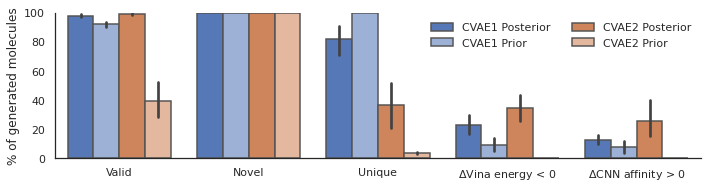

In [236]:
y = [mol_val_col, mol_nov_col, mol_unq_col, lower_vina_aff_col, higher_cnn_aff_col]
hue = [model_col, post_prior_col]

agg_df['asdf'] = agg_df[hue].apply(lambda x: ' '.join(x), axis=1)

fig = param_search.plot(
    agg_df[
        (agg_df[var_factor_col] == 1.0) &
        (agg_df[post_factor_col].isin({0.0, 1.0})) &
        True
    ].set_index('asdf')[y].stack().reset_index(),
    y=0,
    x='level_1',
    hue='asdf',
    n_cols=2,
    width=10,
    height=3, #8,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(loc='upper right', ncol=2, bbox_to_anchor=[1,1], title=None),

)
ax = fig.axes[0]
ax.set_ylabel('% of generated molecules')
_ = ax.set_xlabel(None)
#txt = fig.suptitle(f'Generating molecules', y=1.05)
lgd = ax.get_legend()
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/post_prior_gen_mols.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)


CVAE1 Posterior
CVAE1 Prior
CVAE2 Posterior
CVAE2 Prior


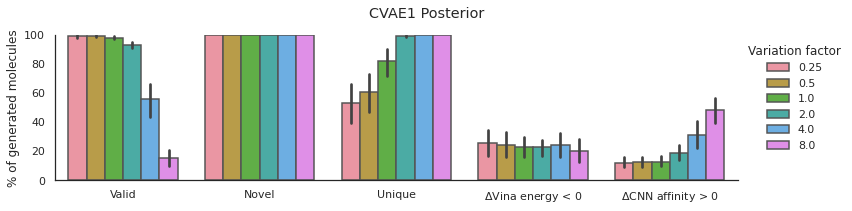

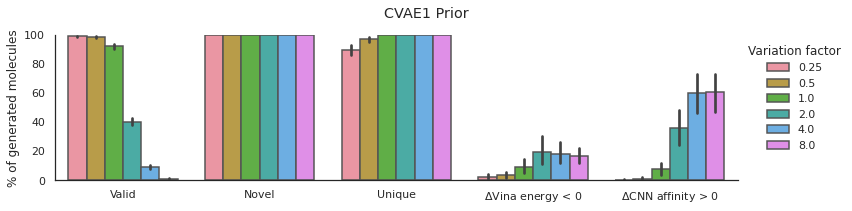

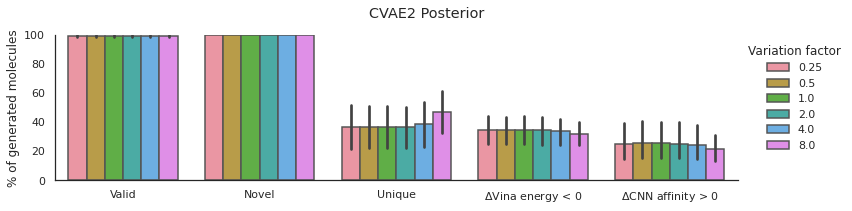

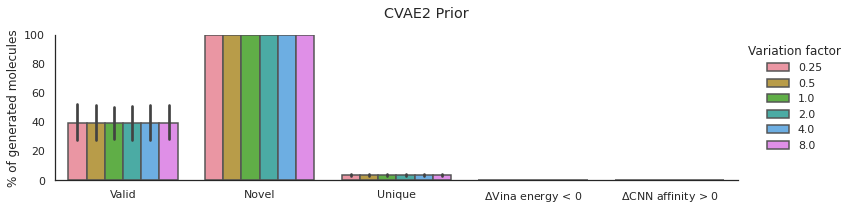

In [249]:
y = [mol_val_col, mol_nov_col, mol_unq_col, lower_vina_aff_col, higher_cnn_aff_col]
hue = var_factor_col

for model_name in ['CVAE1', 'CVAE2']:
    for post_prior in ['Posterior', 'Prior']:
        print(model_name, post_prior)

        fig = param_search.plot(
            agg_df[
                (agg_df[model_col] == model_name) &
                (agg_df[post_prior_col] == post_prior) &
                (agg_df[post_factor_col].isin({0.0, 1.0})) &
                True
            ].set_index(hue)[y].stack().reset_index(),
            y=0,
            x='level_1',
            hue=hue,
            n_cols=1,
            width=12,
            height=3,
            ylim=ylim,
            plot_func=my_gen_plot,
            legend_kws=dict(bbox_to_anchor=[1,1], title=(hue if hue != post_prior_col else None)),
        )
        ax = fig.axes[0]
        ax.set_ylabel('% of generated molecules')
        _ = ax.set_xlabel(None)
        txt = fig.suptitle(f'{model_name} {post_prior}', y=1.05)
        lgd = ax.get_legend()
        for ext in ['png', 'pdf']:
            fig.savefig(f'plots/var_factor_{model_name}_{post_prior}_gen_mols.{ext}', bbox_extra_artists=(txt,lgd), bbox_inches='tight', dpi=400)


CVAE1
CVAE2


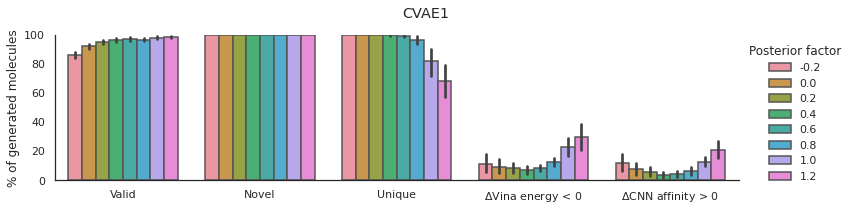

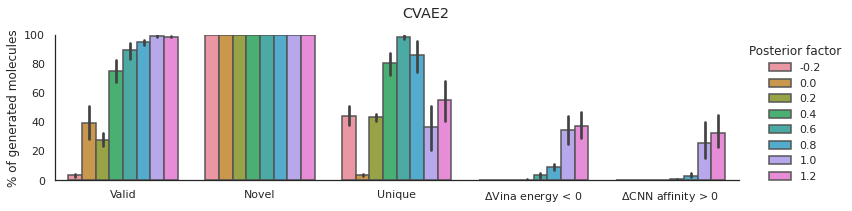

In [250]:
y = [mol_val_col, mol_nov_col, mol_unq_col, lower_vina_aff_col, higher_cnn_aff_col]
hue = post_factor_col

for model_name in ['CVAE1', 'CVAE2']:
    print(model_name)

    fig = param_search.plot(
        agg_df[
            (agg_df[model_col] == model_name) &
            (agg_df[var_factor_col] == 1.0) &
            True
        ].set_index(hue)[y].stack().reset_index(),
        y=0,
        x='level_1',
        hue=hue,
        n_cols=1,
        width=12,
        height=3,
        ylim=ylim,
        plot_func=my_gen_plot,
        legend_kws=dict(bbox_to_anchor=[1,1], title=(hue if hue != post_prior_col else None)),
    )
    ax = fig.axes[0]
    ax.set_ylabel('% of generated molecules')
    _ = ax.set_xlabel(None)
    txt = fig.suptitle(f'{model_name}', y=1.05)
    lgd = ax.get_legend()
    for ext in ['png', 'pdf']:
        fig.savefig(f'plots/post_factor_{model_name}_gen_mols.{ext}', bbox_extra_artists=(txt,lgd), bbox_inches='tight', dpi=400)


In [259]:
colors = get_palette(
    n_hues=2,
    n_shades=1,
    #min_val=0.2
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]

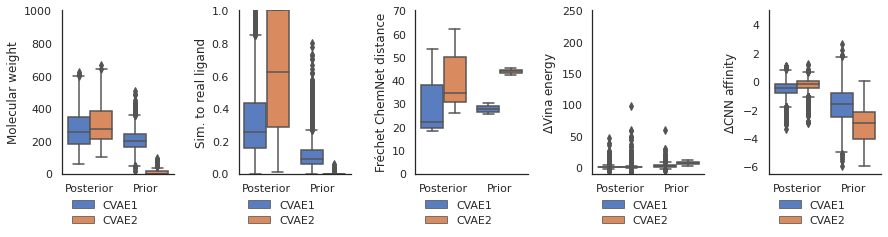

In [285]:
fig = param_search.plot(
    plot_df[
        (plot_df[var_factor_col] == 1.0) &
        (plot_df[post_factor_col].isin({1.0, 0.0})) &
        True
    ],
    y=gen_y,
    x=post_prior_col,
    hue=model_col,
    n_cols=5,
    width=2.5,
    height=3.5,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
    tight=True
)
for ax in fig.axes:
    ax.set_xlabel(None)
    
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/post_prior_box_plots.{ext}', bbox_extra_artists=(ax.get_legend(),), bbox_inches='tight', dpi=400)

CVAE1 Posterior
CVAE1 Prior
CVAE2 Posterior
CVAE2 Prior


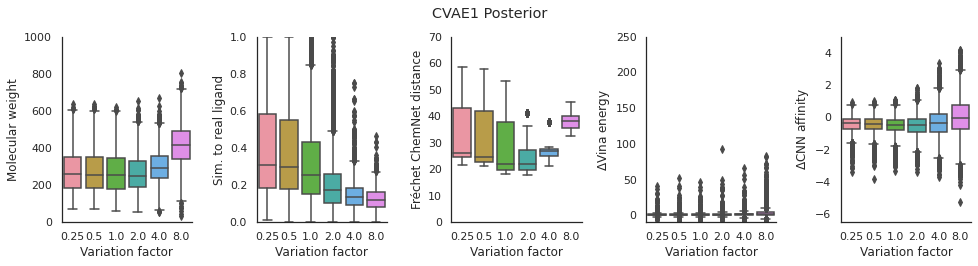

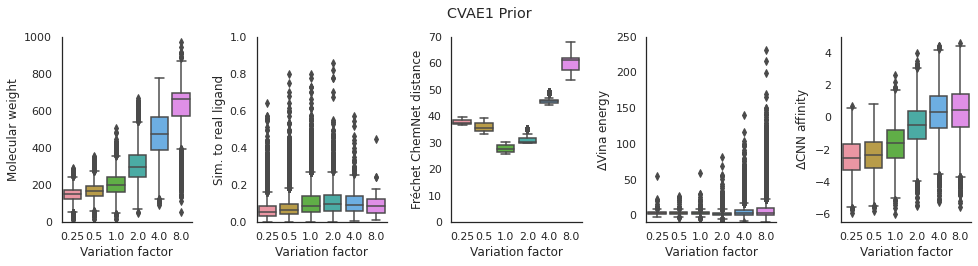

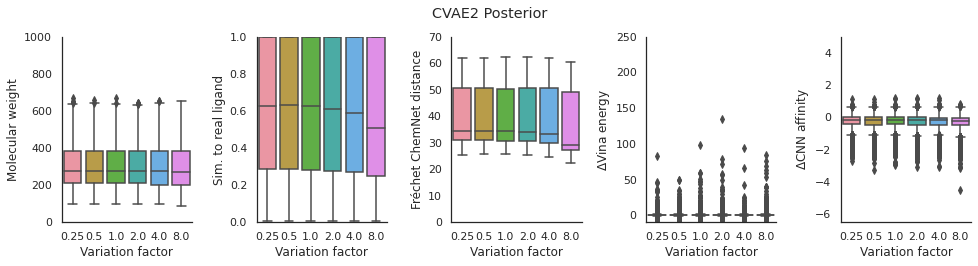

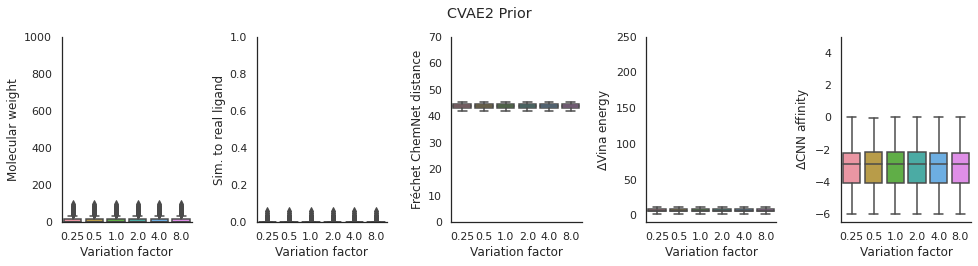

In [293]:
for model_name in ['CVAE1', 'CVAE2']:
    for post_prior in ['Posterior', 'Prior']:
        print(model_name, post_prior)

        fig = param_search.plot(
            plot_df[
                (plot_df[model_col] == model_name) &
                (plot_df[post_prior_col] == post_prior) &
                (plot_df[post_factor_col].isin({0.0, 1.0})) & 
                True
            ],
            y=gen_y,
            x=var_factor_col,
            hue=None,
            n_cols=5,
            width=2.75,
            height=3.5,
            ylim=ylim,
            plot_func=my_gen_plot,
            legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
            tight=True
        )
        txt = fig.suptitle(f'{model_name} {post_prior}', y=1.05)
        #for ax in fig.axes:
        #    ax.set_xlabel(None)
    
        for ext in ['pdf', 'png']:
            fig.savefig(
                f'plots/var_factor_{model_name}_{post_prior}_box_plots.{ext}',
                bbox_extra_artists=(txt,),
                bbox_inches='tight',
                dpi=400,
            )

CVAE1
CVAE2


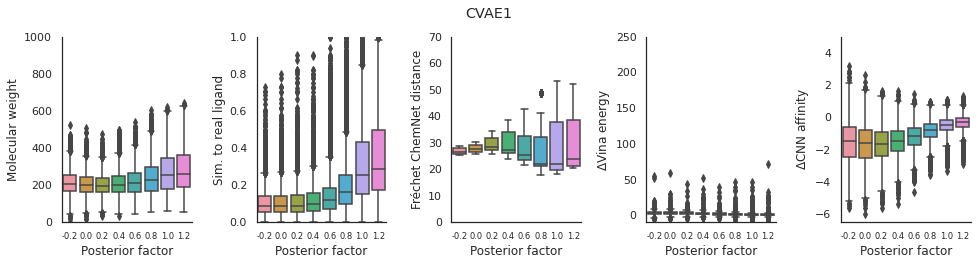

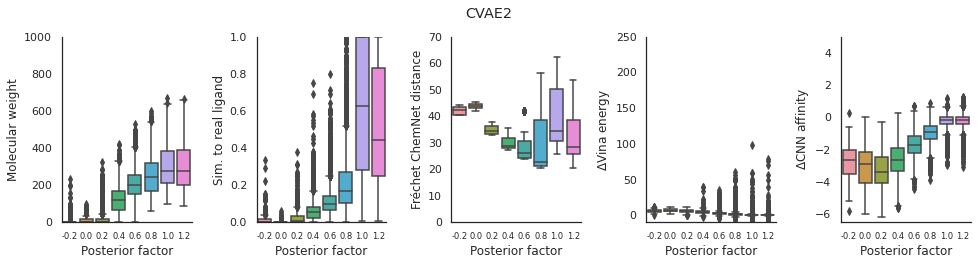

In [292]:
for model_name in ['CVAE1', 'CVAE2']:
    print(model_name)

    fig = param_search.plot(
        plot_df[
            (plot_df[model_col] == model_name) &
            (plot_df[var_factor_col] == 1.0) &
            True
        ],
        y=gen_y,
        x=post_factor_col,
        hue=None,
        n_cols=5,
        width=2.75,
        height=3.5,
        ylim=ylim,
        plot_func=my_gen_plot,
        legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
        tight=True
    )
    txt = fig.suptitle(f'{model_name}', y=1.05)
    #for ax in fig.axes:
    #    ax.set_xlabel(None)
    for ax in fig.axes:
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-small')

    for ext in ['pdf', 'png']:
        fig.savefig(
            f'plots/post_factor_{model_name}_box_plots.{ext}',
            bbox_extra_artists=(txt,),
            bbox_inches='tight',
            dpi=400,
        )

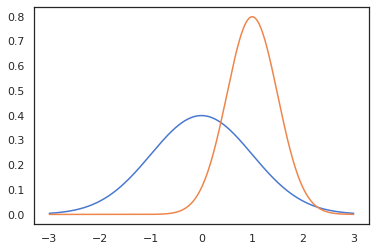

In [305]:
from scipy.stats import norm
x = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
for mean, std in [(0, 1), (1,0.5)]:
    y = norm(mean, std).pdf(x)
    ax.plot(x,y)